# Aspect Based Sentiment Analysis


### Data And Code

For the evalution for proposed methods training and testing data from the SemEal-2014 are used. It contains 3000 training and 800 testing sentences from restaurant review.

In [1]:
# import all necessary packeges
import pandas as pd
import xml.etree.ElementTree as ET, getopt, logging, sys, random, re, copy
from xml.sax.saxutils import escape
import io


from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")





## Fetching Data

In [2]:
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
xml_data1 = open('D:\ABSA\semeval_data\Restaurants_Train.xml').read()

                                                        # Fetch the sentence data
def xml2df(xml_data):
    root = ET.XML(xml_data) # element tree
    all_records = [] #This is our record list which we will convert into a dataframe
    for i, child in enumerate(root): #Begin looping through our root tree
        record = {} #Place holder for our record
        for subchild in child: #iterate through the subchildren to user-agent, Ex: ID, String, Description.
            if(subchild.tag == 'text'):
                record[subchild.tag] = subchild.text
                all_records.append(record)
            #record[subchild.tag] = subchild.text #Extract the text create a new dictionary key, value pair
            #print(subchild.text)
            #all_records.append(record) #Append this record to all_records.
            
    return pd.DataFrame(all_records) #return records as DataFrame

#  Fetching Id
def iter_docs(sentences):
    author_attr = sentences.attrib
    for doc in sentences.iter('sentence'):
        
        #print(doc.find('text'))
        doc_dict = author_attr.copy()
        #print(author_attr['aspectTerm'])
        #print(doc.attrib)
        doc_dict.update(doc.attrib)  # doc.attribute give the value of the sentence id e.g. {'id': 12334}
        #doc_dict['data'] = doc.text
        #print(doc_dict)
        yield doc_dict
        


xml_data = io.StringIO(xml_data1)

etree = ET.parse(xml_data) #create an ElementTree object 
doc_df = pd.DataFrame(list(iter_docs(etree.getroot())))


sentence_data = xml2df(xml_data1)



print(doc_df)

print(sentence_data) 

        id
0     3121
1     2777
2     1634
3     2534
4      583
5     2846
6     1571
7     1458
8     3161
9     2391
10     986
11     296
12    1793
13    2200
14    3195
15    3119
16    3359
17      70
18    1829
19    2935
20    1805
21    2559
22     716
23    2464
24     385
25    1350
26    3534
27    1407
28     565
29     387
...    ...
3014   902
3015   568
3016  3133
3017  2553
3018  2624
3019  2116
3020   317
3021  2151
3022   944
3023  3014
3024   900
3025  2739
3026   279
3027  2937
3028   333
3029   236
3030  1420
3031  2259
3032   608
3033  2834
3034  3168
3035  2798
3036  2378
3037  1027
3038  1735
3039  1063
3040   777
3041   875
3042   671
3043   617

[3044 rows x 1 columns]
                                                   text
0                  But the staff was so horrible to us.
1     To be completely fair, the only redeeming fact...
2     The food is uniformly exceptional, with a very...
3     Where Gabriela personaly greets you and recomm...
4     For tho

In [3]:
print(sum(sentence_data.duplicated('text')))

6


In [46]:
sentence_data

,text
0,But the staff was so horrible to us.
1,"To be completely fair, the only redeeming fact..."
2,"The food is uniformly exceptional, with a very..."
3,Where Gabriela personaly greets you and recomm...
4,"For those that go once and don't enjoy it, all..."
5,"Not only was the food outstanding, but the lit..."
6,It is very overpriced and not very tasty.
7,Our agreed favorite is the orrechiete with sau...
8,The Bagels have an outstanding taste with a te...
9,Nevertheless the food itself is pretty good.


#### For the Aspect Term Data

In [4]:
aspects_records = []
for node in etree.iter():
    record = {}
    
    #print(node.attrib)
    #print(node.tag)
    
    
    if(node.tag == 'sentence'):
        id = node.attrib.get('id')
        #print("1:",id)
        
    if(node.tag == 'aspectTerm' ):
        
        #print("2",id)
        record['id'] = id
        record['term'] = node.attrib.get('term')
        record['polarity'] = node.attrib.get('polarity')
        record['from'] = node.attrib.get('from')
        record['to'] = node.attrib.get('to')
        aspects_records.append(record)
    #print(node.attrib.get('id'))

    
    #record[node.tag] = node.attrib
    #all_records.append(record)
    
    #pd.DataFrame(all_records)
    #print ("Tag:",node.tag)
    
    #print("Sentence:",node.find('text').text)
    
    #print("Value:", node.attrib.get('id'))
    
    
    #print (node.attrib) record['aaa'] = '111'
   # print ("Term:",node.attrib.get('term'),"Polarity:", node.attrib.get('polarity'), "From:", node.attrib.get('From'), "To", node.attrib.get('to'))
   # print ("Polarity", node.attrib.get('polarity'))
   #print ("From", node.attrib.get('to'))



#print(doc_df1)

In [5]:

aspect_terms = pd.DataFrame(aspects_records)
aspect_terms

,from,id,polarity,term,to
0,8,3121,negative,staff,13
1,57,2777,positive,food,61
2,4,1634,positive,food,8
3,55,1634,positive,kitchen,62
4,141,1634,neutral,menu,145
5,17,2846,positive,food,21
6,51,2846,positive,perks,56
7,27,1458,positive,orrechiete with sausage and chicken,62
8,76,1458,positive,waiters,83
9,152,1458,neutral,meats,157


### Sentence Catergory Table

In [6]:
aspect_category_records = []
for node in etree.iter():
    record = {} 
    #print(node.attrib)
    #print(node.tag)
    
    
    if(node.tag == 'sentence'):
        id = node.attrib.get('id')
        #print("1:",id)
        
    if(node.tag == 'aspectCategory' ):
        
        #print("2",id)
        record['id'] = id
        record['category'] = node.attrib.get('category')
        record['polarity'] = node.attrib.get('polarity')
        
        aspect_category_records.append(record)

In [7]:
aspect_category = pd.DataFrame(aspect_category_records)
aspect_category

,category,id,polarity
0,service,3121,negative
1,food,2777,positive
2,anecdotes/miscellaneous,2777,negative
3,food,1634,positive
4,service,2534,positive
5,anecdotes/miscellaneous,583,positive
6,food,2846,positive
7,service,2846,positive
8,food,1571,negative
9,price,1571,negative


In [8]:
print("Number of data points", doc_df.shape[0])
print("Number of data points", doc_df.shape[1])
print("Number of data points", sentence_data.shape[0])
print("Number of data points", sentence_data.shape[1])

Number of data points 3044
Number of data points 1
Number of data points 3044
Number of data points 1


In [62]:
text_data = pd.concat([doc_df, sentence_data], axis=1)

In [56]:
text_data

,id,text
0,3121,But the staff was so horrible to us.
1,2777,"To be completely fair, the only redeeming fact..."
2,1634,"The food is uniformly exceptional, with a very..."
3,2534,Where Gabriela personaly greets you and recomm...
4,583,"For those that go once and don't enjoy it, all..."
5,2846,"Not only was the food outstanding, but the lit..."
6,1571,It is very overpriced and not very tasty.
7,1458,Our agreed favorite is the orrechiete with sau...
8,3161,The Bagels have an outstanding taste with a te...
9,2391,Nevertheless the food itself is pretty good.


In [11]:
text_data.columns

Index(['id', 'text'], dtype='object')

In [12]:
print("Number of features points", doc_df.shape[1])

Number of features points 1


In [13]:
doc_df.columns

Index(['id'], dtype='object')

### Basic Status of the data
1. Sentence Table (text_data)
2. Aspect Terms Data (aspect_terms)
3. Category Data (aspect_category)

In [55]:
#colums in text_data
text_data.columns

Index(['id', 'text'], dtype='object')

In [56]:
#describe text data
print(text_data['text'].describe())

count           3044
unique          3038
top       Good food.
freq               2
Name: text, dtype: object


In [88]:
#Aspect colums 
aspect_terms.columns

Index(['from', 'id', 'polarity', 'term', 'to'], dtype='object')

In [89]:
#Describe term in the aspects
print(aspect_terms['term'].describe())

count     3699
unique    1295
top       food
freq       358
Name: term, dtype: object


In [90]:
# Category columns
aspect_category.columns

Index(['category', 'id', 'polarity'], dtype='object')

In [91]:
# Describe category 
print(aspect_category['category'].describe())

count     3714
unique       5
top       food
freq      1233
Name: category, dtype: object


In [93]:
aspect_terms['term'].unique()

array(['staff', 'food', 'kitchen', ..., 'cheese sticks',
       'pot of boiling water', 'glass noodles'], dtype=object)

In [94]:
aspect_category['category'].unique()

array(['service', 'food', 'anecdotes/miscellaneous', 'price', 'ambience'], dtype=object)

In [14]:
# store thr sentence text data into the pickels/180k_text_data
text_data.to_pickle('pickels/180k_text_data')
aspect_terms.to_pickle('pickels/180k_aspect_data')
aspect_category.to_pickle('pickels/180k_category_data')

In [213]:
print("thie sedif dfdf dfdf".split())

['thie', 'sedif', 'dfdf', 'dfdf']


## 2. Text Preprocessing

In [15]:
# Remove the special charecter in the string 

string = "special character $# df_*d dfa chara spaces 88823434"
''.join(e for e in string if e.isalnum())


'specialcharacterdfddfacharaspaces88823434'

### Lemmatization

Here


In [22]:
from nltk.corpus import wordnet
emmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [29]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


In [63]:
text = word_tokenize("It is better.")
print ("Tokenized Text", text)
print(len(word_tokenize("It is better.")))

a = nltk.pos_tag(text)
def nlp_lemmatizing(total_text, index, column):
    if(total_text) is not int:
        string = ""
        total_text= word_tokenize(total_text)
        a = nltk.pos_tag(total_text)
        print ('a: ', a)
        for w in a:
            try:
                string += lemmatizer.lemmatize(w[0],get_wordnet_pos(w[1])) +" "
            except:
                string += w[0] + " "
    text_data[column][index] = string 
                
            
            
s = []
for w in a:
    #print (w[0])
    #print (w[1])
    try:
        print(lemmatizer.lemmatize(w[0],get_wordnet_pos(w[1])))
        s.append(lemmatizer.lemmatize(w[0],get_wordnet_pos(w[1])))
    except :
        print(lemmatizer.lemmatize(w[0])) 
        s.append(w[0])   
print (s)       

Tokenized Text ['It', 'is', 'better', '.']
4
It
be
well
.
['It', 'be', 'well', '.']


In [64]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in text_data.iterrows():
    nlp_lemmatizing(row['text'], index, 'text')

# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

a:  [('But', 'CC'), ('the', 'DT'), ('staff', 'NN'), ('was', 'VBD'), ('so', 'RB'), ('horrible', 'JJ'), ('to', 'TO'), ('us', 'PRP'), ('.', '.')]
a:  [('To', 'TO'), ('be', 'VB'), ('completely', 'RB'), ('fair', 'JJ'), (',', ','), ('the', 'DT'), ('only', 'JJ'), ('redeeming', 'NN'), ('factor', 'NN'), ('was', 'VBD'), ('the', 'DT'), ('food', 'NN'), (',', ','), ('which', 'WDT'), ('was', 'VBD'), ('above', 'IN'), ('average', 'NN'), (',', ','), ('but', 'CC'), ('could', 'MD'), ("n't", 'RB'), ('make', 'VB'), ('up', 'RP'), ('for', 'IN'), ('all', 'PDT'), ('the', 'DT'), ('other', 'JJ'), ('deficiencies', 'NNS'), ('of', 'IN'), ('Teodora', 'NNP'), ('.', '.')]
a:  [('The', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('uniformly', 'JJ'), ('exceptional', 'JJ'), (',', ','), ('with', 'IN'), ('a', 'DT'), ('very', 'RB'), ('capable', 'JJ'), ('kitchen', 'NN'), ('which', 'WDT'), ('will', 'MD'), ('proudly', 'RB'), ('whip', 'VB'), ('up', 'RP'), ('whatever', 'WDT'), ('you', 'PRP'), ('feel', 'VBP'), ('like', 'IN'), ('eating'

a:  [('I', 'PRP'), ('heartily', 'RB'), ('recommend', 'VBP'), ('.', '.')]
a:  [('Heartland', 'NNP'), ('Brewery', 'NNP'), ('is', 'VBZ'), ('by', 'IN'), ('far', 'RB'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('places', 'NNS'), ('in', 'IN'), ('NYC', 'NNP'), ('to', 'TO'), ('make', 'VB'), ('new', 'JJ'), ('friends', 'NNS'), ('and', 'CC'), ('catch', 'VB'), ('up', 'RP'), ('with', 'IN'), ('old', 'JJ'), ('ones', 'NNS'), ('.', '.')]
a:  [('I', 'PRP'), ('almost', 'RB'), ('hesititate', 'NN'), ('to', 'TO'), ('write', 'VB'), ('a', 'DT'), ('review', 'NN'), ('because', 'IN'), ('the', 'DT'), ('atmosphere', 'NN'), ('was', 'VBD'), ('so', 'RB'), ('great', 'JJ'), ('and', 'CC'), ('I', 'PRP'), ('would', 'MD'), ('hate', 'VB'), ('for', 'IN'), ('it', 'PRP'), ('too', 'RB'), ('become', 'VBZ'), ('to', 'TO'), ('crowded', 'VB'), ('.', '.')]
a:  [('They', 'PRP'), ('are', 'VBP'), ('often', 'RB'), ('crowded', 'VBN'), ('on', 'IN'), ('the', 'DT'), ('weekends', 'NNS'), ('but', 'CC'), ('they', 'PRP'), ('a

a:  [('I', 'PRP'), ('understand', 'VBP'), ('the', 'DT'), ('area', 'NN'), ('and', 'CC'), ('folks', 'NNS'), ('you', 'PRP'), ('need', 'VBP'), ('not', 'RB'), ('come', 'VBN'), ('here', 'RB'), ('for', 'IN'), ('the', 'DT'), ('romantic', 'JJ'), (',', ','), ('alluring', 'VBG'), ('ambiance', 'NN'), ('or', 'CC'), ('the', 'DT'), ('five', 'CD'), ('star', 'NN'), ('service', 'NN'), ('featuring', 'VBG'), ('a', 'DT'), ('sommlier', 'NN'), ('and', 'CC'), ('a', 'DT'), ('complicated', 'JJ'), ('maze', 'NN'), ('of', 'IN'), ('captain', 'NN'), ('and', 'CC'), ('back', 'NN'), ('waiters', 'NNS'), ('-', ':'), ('you', 'PRP'), ('come', 'VBP'), ('for', 'IN'), ('the', 'DT'), ('authentic', 'JJ'), ('foods', 'NNS'), (',', ','), ('the', 'DT'), ('tastes', 'NNS'), (',', ','), ('the', 'DT'), ('experiance', 'NN'), ('.', '.')]
a:  [('Went', 'NN'), ('with', 'IN'), ('mommy', 'NN'), ('(', '('), ('the', 'DT'), ('only', 'RB'), ('person', 'NN'), ('who', 'WP'), ('could', 'MD'), ('afford', 'VB'), ('taking', 'VBG'), ('me', 'PRP'), ('he

a:  [('This', 'DT'), ('has', 'VBZ'), ('got', 'VBN'), ('to', 'TO'), ('be', 'VB'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('most', 'RBS'), ('overrated', 'JJ'), ('restaurants', 'NNS'), ('in', 'IN'), ('Brooklyn', 'NNP'), ('.', '.')]
a:  [('The', 'DT'), ('service', 'NN'), (',', ','), ('wine', 'JJ'), ('selection', 'NN'), (',', ','), ('ambiance', 'NN'), ('are', 'VBP'), ('all', 'DT'), ('outstanding', 'JJ'), ('and', 'CC'), ('deserve', 'JJ'), ('recognition', 'NN'), ('.', '.')]
a:  [('Went', 'NN'), ('there', 'EX'), ('last', 'JJ'), ('night', 'NN'), ('for', 'IN'), ('2', 'CD'), ('year', 'NN'), ('anniversery', 'NN'), (',', ','), ('and', 'CC'), ('was', 'VBD'), ("n't", 'RB'), ('all', 'PDT'), ('that', 'DT'), ('impressed', 'VBD'), ('.', '.')]
a:  [('It', 'PRP'), ('was', 'VBD'), ('rather', 'RB'), ('pathetic', 'JJ'), ('that', 'IN'), ('it', 'PRP'), ('took', 'VBD'), ('them', 'PRP'), ('over', 'RP'), ('an', 'DT'), ('hour', 'NN'), ('to', 'TO'), ('seat', 'VB'), ('us', 'PRP'), ('.', '.')]
a:  [('We', 'PRP'),

a:  [('Try', 'VB'), ('the', 'DT'), ('cheesecake', 'NN'), ('!', '.')]
a:  [('As', 'IN'), ('we', 'PRP'), ('were', 'VBD'), ('sitting', 'VBG'), ('eating', 'VBG'), ('the', 'DT'), ('subpar', 'NN'), ('food', 'NN'), ('the', 'DT'), ('manager', 'NN'), ('proceeded', 'VBD'), ('to', 'TO'), ('berate', 'VB'), ('a', 'DT'), ('couple', 'NN'), ('of', 'IN'), ('his', 'PRP$'), ('employees', 'NNS'), ('for', 'IN'), ('putting', 'VBG'), ('out', 'RP'), ('the', 'DT'), ('wrong', 'JJ'), ('containers', 'NNS'), ('for', 'IN'), ('condiments', 'NNS'), ('and', 'CC'), ('explained', 'VBD'), ('to', 'TO'), ('them', 'PRP'), ('how', 'WRB'), ('expensive', 'JJ'), ('these', 'DT'), ('containers', 'NNS'), ('were', 'VBD'), ('.', '.')]
a:  [('David', 'NNP'), (',', ','), ('Daytona', 'NNP'), ('Beach', 'NNP'), (',', ','), ('FL', 'NNP')]
a:  [('Perhaps', 'RB'), ('.', '.')]
a:  [('Great', 'NNP'), ('Indian', 'JJ'), ('food', 'NN'), ('and', 'CC'), ('the', 'DT'), ('service', 'NN'), ('is', 'VBZ'), ('incredible', 'JJ'), ('.', '.')]
a:  [('Go', 

a:  [('For', 'IN'), ('the', 'DT'), ('next', 'JJ'), ('hour', 'NN'), ('and', 'CC'), ('a', 'DT'), ('half', 'NN'), ('we', 'PRP'), ('stood', 'VBD'), ('in', 'IN'), ('the', 'DT'), ('crowded', 'JJ'), ('lobby', 'NN'), ('area', 'NN'), ('of', 'IN'), ('this', 'DT'), ('touristy', 'JJ'), ('restaurant', 'NN'), ('listening', 'VBG'), ('to', 'TO'), ('all', 'DT'), ('types', 'NNS'), ('of', 'IN'), ('explanations', 'NNS'), ('of', 'IN'), ('why', 'WRB'), ('we', 'PRP'), ('were', 'VBD'), ('not', 'RB'), ('being', 'VBG'), ('seated', 'VBN'), ('.', '.')]
a:  [('The', 'DT'), ('pizza', 'NN'), ('is', 'VBZ'), ('delicious', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('proprietor', 'NN'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('nicest', 'JJS'), ('in', 'IN'), ('NYC', 'NNP'), ('.', '.')]
a:  [('Also', 'RB'), ('good', 'JJ'), ('for', 'IN'), ('client', 'NN'), ('lunch', 'NN'), ('meetings', 'NNS'), (',', ','), ('esp', 'NN'), ('.', '.')]
a:  [('For', 'IN'), ('$', '$'), ('600', 'CD'), ('(', '('), ('the', 'DT'), ('m

a:  [('Orsay', 'NNP'), (',', ','), ('is', 'VBZ'), ('without', 'IN'), ('a', 'DT'), ('doubt', 'NN'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('values', 'NNS'), ('for', 'IN'), ('authentic', 'JJ'), ('French', 'JJ'), ('food', 'NN'), ('in', 'IN'), ('NYC', 'NNP'), ('.', '.')]
a:  [('I', 'PRP'), ('had', 'VBD'), ('been', 'VBN'), ('searching', 'VBG'), ('really', 'RB'), ('hard', 'JJ'), ('for', 'IN'), ('a', 'DT'), ('restaurant', 'NN'), ('in', 'IN'), ('New', 'NNP'), ('York', 'NNP'), ('where', 'WRB'), ('I', 'PRP'), ('could', 'MD'), ('really', 'RB'), ('feel', 'VB'), ('unwanted', 'JJ'), ('and', 'CC'), ('ignored', 'JJ'), ('and', 'CC'), ('I', 'PRP'), ('finally', 'RB'), ('found', 'VBD'), ('it', 'PRP'), ('!', '.')]
a:  [('It', 'PRP'), ("'s", 'VBZ'), ('definately', 'RB'), ('not', 'RB'), ('a', 'DT'), ('place', 'NN'), ('to', 'TO'), ('go', 'VB'), ('if', 'IN'), ('you', 'PRP'), ('want', 'VBP'), ('to', 'TO'), ('impress', 'VB'), ('someone', 'NN'), ('.', '.')]
a:  [('Well', 'RB'), (',', ','), 

a:  [('The', 'DT'), ('food', 'NN'), ('looked', 'VBD'), ('very', 'RB'), ('appetizing', 'VBG'), ('and', 'CC'), ('delicious', 'JJ'), ('since', 'IN'), ('it', 'PRP'), ('came', 'VBD'), ('on', 'IN'), ('a', 'DT'), ('variety', 'NN'), ('of', 'IN'), ('fancy', 'JJ'), ('plates', 'NNS'), ('.', '.')]
a:  [('Both', 'DT'), ('the', 'DT'), ('fresh', 'JJ'), ('mozzerella', 'NN'), ('slices', 'NNS'), ('and', 'CC'), ('the', 'DT'), ('Plain', 'NNP'), ('Cheese', 'NNP'), ('slice', 'NN'), ('are', 'VBP'), ('phenomenal', 'JJ'), ('.', '.')]
a:  [('I', 'PRP'), ('have', 'VBP'), ('tried', 'VBN'), ('literally', 'RB'), ('every', 'DT'), ('restaurant', 'NN'), ('on', 'IN'), ('curry', 'NN'), ('row', 'NN'), ('.', '.')]
a:  [('The', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('terrible', 'JJ'), ('and', 'CC'), ('overall', 'JJ'), (',', ','), ('I', 'PRP'), ('would', 'MD'), ('have', 'VB'), ('to', 'TO'), ('say', 'VB'), ('avoid', 'NN'), ('at', 'IN'), ('all', 'DT'), ('costs', 'NNS'), ('.', '.')]
a:  [('I', 'PRP'), ("'ve", 'VBP'), ('been', 

a:  [('Katz', 'NNP'), ("'s", 'POS'), ('has', 'VBZ'), ('been', 'VBN'), ('a', 'DT'), ('NYC', 'NNP'), ('original', 'JJ'), ('for', 'IN'), ('over', 'IN'), ('100', 'CD'), ('years', 'NNS'), ('.', '.')]
a:  [('You', 'PRP'), ('can', 'MD'), ('get', 'VB'), ('an', 'DT'), ('excellent', 'JJ'), ('meal', 'NN'), ('at', 'IN'), ('most', 'JJS'), ('of', 'IN'), ('the', 'DT'), ('many', 'JJ'), ('Indian', 'JJ'), ('restaurants', 'NNS'), ('on', 'IN'), ('nearby', 'JJ'), ('Lexington', 'NNP'), ('Avenue', 'NNP'), ('for', 'IN'), ('the', 'DT'), ('cost', 'NN'), ('of', 'IN'), ('one', 'CD'), ('the', 'DT'), ('dainty', 'NN'), ('dishes', 'VBZ'), ('here', 'RB'), ('.', '.')]
a:  [('The', 'DT'), ('Pastrami', 'NNP'), ('sandwich', 'NN'), ('was', 'VBD'), ('like', 'IN'), ('buttah', 'NN'), ('and', 'CC'), ('with', 'IN'), ('pickles', 'NNS'), ('and', 'CC'), ('an', 'DT'), ('icy', 'NN'), ('cold', 'NN'), ('beer', 'NN'), ('to', 'TO'), ('wash', 'VB'), ('it', 'PRP'), ('down', 'RP'), (',', ','), ('it', 'PRP'), ('was', 'VBD'), ('a', 'DT'), ('

a:  [('But', 'CC'), ('do', 'VBP'), ("n't", 'RB'), ('ever', 'RB'), ('order', 'NN'), ('bacon', 'NN'), ('late', 'RB'), ('at', 'IN'), ('nite', 'JJ'), ('(', '('), ('either', 'CC'), ('platter', 'NN'), ('or', 'CC'), ('in', 'IN'), ('sandwiches', 'NNS'), (',', ','), ('for', 'IN'), ('that', 'DT'), ('matter', 'NN'), ('do', 'VBP'), ("n't", 'RB'), ('from', 'IN'), ('any', 'DT'), ('take', 'VB'), ('out', 'RP'), ('place', 'NN'), (')', ')'), ('as', 'IN'), ('it', 'PRP'), ('is', 'VBZ'), ('from', 'IN'), ('the', 'DT'), ('morning', 'NN'), ('frying', 'NN'), ('turns', 'VBZ'), ('out', 'RP'), ('hard', 'RB'), ('almost', 'RB'), ('like', 'IN'), ('bacos', 'NN'), (',', ','), ('hurt', 'VB'), ('my', 'PRP$'), ('molars', 'NNS'), ('.', '.')]
a:  [('Outstanding', 'VBG'), ('Bagels', 'NNP'), (',', ','), ('but', 'CC'), ('you', 'PRP'), ('get', 'VBP'), ('what', 'WP'), ('you', 'PRP'), ('pay', 'VBP'), ('for', 'IN'), ('.', '.')]
a:  [('Pizza', 'NNP'), ('-', ':'), ('the', 'DT'), ('only', 'JJ'), ('pizza', 'NN'), ('in', 'IN'), ('NYC'

a:  [('It', 'PRP'), ("'s", 'VBZ'), ('a', 'DT'), ('shame', 'NN'), ('that', 'IN'), ('a', 'DT'), ('nice', 'JJ'), (',', ','), ('convenient', 'JJ'), ('place', 'NN'), ('like', 'IN'), ('the', 'DT'), ('Pink', 'NNP'), ('Pony', 'NNP'), ('can', 'MD'), ('be', 'VB'), ('so', 'RB'), ('ruined', 'VBN'), ('by', 'IN'), ('lousy', 'JJ'), ('service', 'NN'), ('.', '.')]
a:  [('This', 'DT'), ('is', 'VBZ'), ('the', 'DT'), ('first', 'JJ'), ('time', 'NN'), ('Citysearch', 'NNP'), ("did't", 'NN'), ('call', 'NN'), ('it', 'PRP'), ('right', 'RB'), ('.', '.')]
a:  [('You', 'PRP'), ('should', 'MD'), ('pass', 'VB'), ('on', 'IN'), ('the', 'DT'), ('calamari', 'NN'), ('.', '.')]
a:  [('The', 'DT'), ('porcini', 'NN'), ('mushroom', 'NN'), ('pasta', 'NN'), ('special', 'JJ'), ('was', 'VBD'), ('tasteless', 'JJ'), (',', ','), ('so', 'RB'), ('was', 'VBD'), ('the', 'DT'), ('seafood', 'NN'), ('tagliatelle', 'NN'), ('.', '.')]
a:  [('Try', 'VB'), ('the', 'DT'), ('spicy', 'NN'), ('wontons', 'NNS'), ('and', 'CC'), ('the', 'DT'), ('sal

a:  [('However', 'RB'), (',', ','), ('it', 'PRP'), ('just', 'RB'), ('so', 'RB'), ('happens', 'VBZ'), ('that', 'IN'), ('there', 'EX'), ("'s", 'VBZ'), ('an', 'DT'), ('even', 'RB'), ('more', 'RBR'), ('amazing', 'JJ'), ('place', 'NN'), ('just', 'RB'), ('down', 'IN'), ('the', 'DT'), ('street', 'NN'), ('.', '.')]
a:  [('While', 'IN'), ('there', 'EX'), ('are', 'VBP'), ('plenty', 'NN'), ('of', 'IN'), ('places', 'NNS'), ('to', 'TO'), ('go', 'VB'), ('for', 'IN'), ('a', 'DT'), ('good', 'JJ'), ('corned', 'VBN'), ('beef', 'NN'), ('sandwich', 'NN'), (',', ','), ('Katz', 'NNP'), ("'s", 'POS'), ('has', 'VBZ'), ('a', 'DT'), ('charm', 'NN'), ('about', 'IN'), ('it', 'PRP'), ('.', '.')]
a:  [('However', 'RB'), (',', ','), ('looking', 'VBG'), ('at', 'IN'), ('the', 'DT'), ('table', 'NN'), ('next', 'JJ'), ('to', 'TO'), ('ours', 'VB'), (',', ','), ('we', 'PRP'), ('both', 'DT'), ('sort', 'NN'), ('of', 'IN'), ('wished', 'VBN'), ('we', 'PRP'), ('had', 'VBD'), ('ordered', 'VBN'), ('pizza', 'NN'), (',', ','), ('wh

a:  [('I', 'PRP'), ("'m", 'VBP'), ('glad', 'JJ'), ('I', 'PRP'), ('was', 'VBD'), ('introduced', 'VBN'), ('to', 'TO'), ('this', 'DT'), ('place', 'NN'), ('and', 'CC'), ('this', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('rare', 'JJ'), ('gem', 'NN'), ('in', 'IN'), ('NY', 'NNP'), ('.', '.')]
a:  [('And', 'CC'), ('at', 'IN'), ('the', 'DT'), ('conclusion', 'NN'), ('of', 'IN'), ('this', 'DT'), ('culinary', 'JJ'), ('nightmare', 'NN'), ('the', 'DT'), ('check', 'NN'), ('was', 'VBD'), ('given', 'VBN'), ('to', 'TO'), ('our', 'PRP$'), ('table', 'NN'), ('by', 'IN'), ('knocking', 'VBG'), ('over', 'RP'), ('a', 'DT'), ('glass', 'NN'), ('of', 'IN'), ('water', 'NN'), ('.', '.')]
a:  [('Not', 'RB'), ('a', 'DT'), ('small', 'JJ'), ('feat', 'NN'), ('for', 'IN'), ('good', 'JJ'), ('french', 'JJ'), ('food', 'NN'), ('in', 'IN'), ('the', 'DT'), ('area', 'NN'), ('.', '.')]
a:  [('The', 'DT'), ('space', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('bit', 'NN'), ('too', 'RB'), ('small', 'JJ'), ('for', 'IN'), ('live', 'JJ'), ('music'

a:  [('Stuffing', 'VBG'), ('yourself', 'PRP'), ('with', 'IN'), ('Japanese', 'JJ'), ('food', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('rare', 'JJ'), ('thing', 'NN'), ('.', '.')]
a:  [('I', 'PRP'), ('try', 'VBP'), ('my', 'PRP$'), ('best', 'JJS'), ('to', 'TO'), ('give', 'VB'), ('an', 'DT'), ('accurate', 'JJ'), ('description', 'NN'), ('of', 'IN'), ('any', 'DT'), ('establishment', 'NN'), ('visited', 'VBN'), ('.', '.')]
a:  [('While', 'IN'), ('the', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('good', 'JJ'), ('(', '('), ('certainly', 'RB'), ('no', 'DT'), ('Il', 'NNP'), ('Mulino', 'NNP'), (')', ')'), ('the', 'DT'), ('service', 'NN'), ('was', 'VBD'), ('horrendous', 'JJ'), ('.', '.')]
a:  [('It', 'PRP'), ('is', 'VBZ'), ('expensive', 'JJ'), ('but', 'CC'), ('well', 'RB'), ('worth', 'IN'), ('the', 'DT'), ('money', 'NN'), ('.', '.')]
a:  [('Service', 'NNP'), ('is', 'VBZ'), ('not', 'RB'), ('what', 'WP'), ('one', 'CD'), ('would', 'MD'), ('expect', 'VB'), ('from', 'IN'), ('a', 'DT'), ('joint', 'JJ'), ('in', 'IN

a:  [('We', 'PRP'), ("'ve", 'VBP'), ('been', 'VBN'), ('to', 'TO'), ('Grocery', 'NNP'), ('three', 'CD'), ('times', 'NNS'), ('and', 'CC'), ('not', 'RB'), ('once', 'RB'), ('has', 'VBZ'), ('an', 'DT'), ('item', 'NN'), ('on', 'IN'), ('the', 'DT'), ('menu', 'NN'), ('disappointed', 'VBD'), ('.', '.')]
a:  [('The', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('very', 'RB'), ('good', 'JJ'), ('too', 'RB'), ('but', 'CC'), ('for', 'IN'), ('the', 'DT'), ('most', 'JJS'), ('part', 'NN'), (',', ','), ('it', 'PRP'), ("'s", 'VBZ'), ('just', 'RB'), ('regular', 'JJ'), ('food', 'NN'), (',', ','), ('nothing', 'NN'), ('special', 'JJ'), ('.', '.')]
a:  [('A', 'DT'), ('touch', 'NN'), ('more', 'JJR'), ('jalapeno', 'JJ'), ('heat', 'NN'), ('for', 'IN'), ('contrast', 'NN'), ('and', 'CC'), ('it', 'PRP'), ('would', 'MD'), ('have', 'VB'), ('been', 'VBN'), ('very', 'RB'), ('good', 'JJ'), ('indeed', 'RB'), ('.', '.')]
a:  [('Tried', 'VBN'), ('the', 'DT'), ('pad', 'NN'), ('see', 'VBP'), ('ew', 'NN'), ('on', 'IN'), ('the', 'DT

a:  [('We', 'PRP'), ('had', 'VBD'), ('a', 'DT'), ('most', 'RBS'), ('unpleasant', 'JJ'), ('experience', 'NN'), ('at', 'IN'), ('this', 'DT'), ('restaurant', 'NN'), ('.', '.')]
a:  [('The', 'DT'), ('spicy', 'NN'), ('tuna', 'NN'), ('roll', 'NN'), ('was', 'VBD'), ('unusually', 'RB'), ('good', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('rock', 'NN'), ('shrimp', 'NN'), ('tempura', 'NN'), ('was', 'VBD'), ('awesome', 'JJ'), (',', ','), ('great', 'JJ'), ('appetizer', 'NN'), ('to', 'TO'), ('share', 'NN'), ('!', '.')]
a:  [('The', 'DT'), ('staff', 'NN'), ('was', 'VBD'), ('knowledgeable', 'JJ'), ('and', 'CC'), ('full', 'JJ'), ('of', 'IN'), ('personality', 'NN'), ('.', '.')]
a:  [('Great', 'JJ'), ('staff', 'NN'), ('.', '.')]
a:  [('Only', 'RB'), ('complaint', 'NN'), ('would', 'MD'), ('be', 'VB'), ('that', 'IN'), ('at', 'IN'), ('an', 'DT'), ('average', 'JJ'), ('cost', 'NN'), ('of', 'IN'), ('$', '$'), ('12-', 'JJ'), ('$', '$'), ('15', 'CD'), ('per', 'IN'), ('meal', 'NN'), (',', ','), ('I', 'PRP'), ("'d", '

a:  [('This', 'DT'), ('place', 'NN'), ('is', 'VBZ'), ('greatly', 'RB'), ('welcome', 'JJ'), ('in', 'IN'), ('the', 'DT'), ('desolate', 'NN'), ('little', 'JJ'), ('strip', 'NN'), ('between', 'IN'), ('the', 'DT'), ('Prospect', 'NNP'), ('Expressway', 'NNP'), ('and', 'CC'), ('Greenwood', 'NNP'), ('Cemetery', 'NNP'), ('-', ':'), ('a', 'DT'), ('wasteland', 'NN'), ('we', 'PRP'), ('like', 'VBP'), ('to', 'TO'), ('call', 'VB'), ('The', 'DT'), ('Sliv', 'NNP'), ('.', '.')]
a:  [('now', 'RB'), ('if', 'IN'), ('they', 'PRP'), ('could', 'MD'), ('only', 'RB'), ('get', 'VB'), ('a', 'DT'), ('toaster', 'NN'), ('.', '.')]
a:  [('You', 'PRP'), ('will', 'MD'), ('find', 'VB'), ('yourself', 'PRP'), ('returning', 'VBG'), ('quite', 'RB'), ('often', 'RB'), ('.', '.')]
a:  [('When', 'WRB'), ('he', 'PRP'), ("'s", 'VBZ'), ('not', 'RB'), ('making', 'VBG'), ('authentic', 'JJ'), ('Neapolitan', 'NNP'), ('pizza', 'NN'), ('in', 'IN'), ('the', 'DT'), ('open', 'JJ'), ('brick', 'NN'), ('oven', 'NN'), ('or', 'CC'), ('lightly', '

a:  [('My', 'PRP$'), ('GF', 'NNP'), ('and', 'CC'), ('I', 'PRP'), ('still', 'RB'), ('choose', 'VBP'), ('to', 'TO'), ('eat', 'VB'), ('there', 'EX'), ('a', 'DT'), ('lot', 'NN'), ('because', 'IN'), ('of', 'IN'), ('diverse', 'NN'), ('cocktails', 'NNS'), (',', ','), ('the', 'DT'), ('chill', 'NN'), ('decor', 'NN'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('decent', 'JJ'), ('sushi', 'NN'), ('.', '.')]
a:  [('We', 'PRP'), ('ended', 'VBD'), ('the', 'DT'), ('dinner', 'NN'), ('with', 'IN'), ('a', 'DT'), ('surprisingly', 'RB'), ('light', 'JJ'), ('and', 'CC'), ('flaky', 'JJ'), ('apple', 'NN'), ('tarte', 'NN'), ('tatin', 'NN'), ('.', '.')]
a:  [('The', 'DT'), ('buffet', 'NN'), ('had', 'VBD'), ('a', 'DT'), ('nice', 'JJ'), ('selection', 'NN'), ('.', '.')]
a:  [('Waitstaff', 'WDT'), ('are', 'VBP'), ('very', 'RB'), ('friendly', 'RB'), ('.', '.')]
a:  [('This', 'DT'), ('restaurant', 'NN'), ('is', 'VBZ'), ('such', 'JJ'), ('a', 'DT'), ('great', 'JJ'), ('place', 'NN'), ('.', '.')]
a:  [('Once', 'RB'), ('yo

a:  [('Not', 'RB'), ('the', 'DT'), ('greatest', 'JJS'), ('sushi', 'JJ'), ('place', 'NN'), (',', ','), ('but', 'CC'), ('excellent', 'NN'), ('for', 'IN'), ('a', 'DT'), ('$', '$'), ('19.95', 'CD'), ('all', 'DT'), ('you', 'PRP'), ('can', 'MD'), ('eat', 'VB'), ('.', '.')]
a:  [('Shockingly', 'RB'), ('easy', 'JJ'), ('to', 'TO'), ('throw', 'VB'), ('a', 'DT'), ('group', 'NN'), ('dinner', 'NN'), ('here', 'RB'), (':', ':'), ('simple', 'JJ'), ('contract', 'NN'), (',', ','), ('deposit', 'NN'), ('only', 'RB'), ('to', 'TO'), ('hold', 'VB'), ('the', 'DT'), ('date', 'NN'), ('the', 'DT'), ('entire', 'JJ'), ('2nd', 'CD'), ('fl', 'NN'), ('mezz', 'NN'), ('for', 'IN'), ('our', 'PRP$'), ('grp', 'NN'), ('of', 'IN'), ('20', 'CD'), ('.', '.')]
a:  [('The', 'DT'), ('Thai', 'NNP'), ('ice', 'NN'), ('tea', 'NN'), ('was', 'VBD'), ('amazingly', 'RB'), ('smooth', 'JJ'), ('and', 'CC'), ('yummy', 'NN'), ('!', '.')]
a:  [('We', 'PRP'), ("'ve", 'VBP'), ('never', 'RB'), ('had', 'VBD'), ('any', 'DT'), ('problems', 'NNS'), 

a:  [('Prices', 'NNS'), ('too', 'RB'), ('high', 'JJ'), ('for', 'IN'), ('this', 'DT'), ('cramped', 'NN'), ('and', 'CC'), ('unappealing', 'JJ'), ('resturant', 'NN'), ('.', '.')]
a:  [('Tuk', 'NNP'), ('Tuk', 'NNP'), ('is', 'VBZ'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('rare', 'JJ'), ('choices', 'NNS'), ('for', 'IN'), ('me', 'PRP'), ('to', 'TO'), ('go', 'VB'), ('in', 'IN'), ('Brooklyn', 'NNP'), ('.', '.')]
a:  [('This', 'DT'), ('quiet', 'JJ'), ('dark', 'JJ'), ('asian', 'JJ'), ('bistro', 'NN'), ('is', 'VBZ'), ('well', 'RB'), ('worth', 'IN'), ('the', 'DT'), ('trip', 'NN'), ('.', '.')]
a:  [('I', 'PRP'), ('knew', 'VBD'), ('upon', 'IN'), ('visiting', 'VBG'), ('NYC', 'NNP'), ('that', 'IN'), ('I', 'PRP'), ('wanted', 'VBD'), ('to', 'TO'), ('try', 'VB'), ('an', 'DT'), ('orginal', 'JJ'), ('deli', 'NN'), ('.', '.')]
a:  [('I', 'PRP'), ('would', 'MD'), ('highly', 'RB'), ('recommend', 'VB'), ('this', 'DT'), ('place', 'NN'), ('!', '.')]
a:  [('Total', 'JJ'), ('hipster-wannabe', 'JJ'), ('attitude

a:  [('As', 'RB'), ('soon', 'RB'), ('as', 'IN'), ('I', 'PRP'), ('wake', 'VBP'), ('up', 'RP'), ('on', 'IN'), ('a', 'DT'), ('saturday', 'NN'), ('or', 'CC'), ('sunday', 'NN'), ('it', 'PRP'), ('is', 'VBZ'), ('the', 'DT'), ('first', 'JJ'), ('thing', 'NN'), ('on', 'IN'), ('my', 'PRP$'), ('mind', 'NN'), ('is', 'VBZ'), ('when', 'WRB'), ('and', 'CC'), ('how', 'WRB'), ('I', 'PRP'), ('will', 'MD'), ('be', 'VB'), ('getting', 'VBG'), ('to', 'TO'), ('fried', 'VBN'), ('dumpling', 'NN'), ('.', '.')]
a:  [('The', 'DT'), ('staff', 'NN'), ('is', 'VBZ'), ("n't", 'RB'), ('the', 'DT'), ('friendliest', 'JJS'), ('or', 'CC'), ('most', 'RBS'), ('competent', 'JJ'), (',', ','), ('and', 'CC'), ('I', 'PRP'), ('am', 'VBP'), ('stickler', 'RB'), ('for', 'IN'), ('service', 'NN'), (',', ','), ('but', 'CC'), ('everything', 'NN'), ('else', 'RB'), ('about', 'IN'), ('this', 'DT'), ('place', 'NN'), ('makes', 'VBZ'), ('up', 'RP'), ('for', 'IN'), ('it', 'PRP'), ('.', '.')]
a:  [('My', 'PRP$'), ('wife', 'NN'), ('and', 'CC'), ('

a:  [('The', 'DT'), ('spicy', 'NN'), ('Tuna', 'NNP'), ('roll', 'NN'), ('is', 'VBZ'), ('huge', 'JJ'), ('and', 'CC'), ('probably', 'RB'), ('the', 'DT'), ('best', 'JJS'), ('that', 'IN'), ('I', 'PRP'), ("'ve", 'VBP'), ('had', 'VBN'), ('at', 'IN'), ('this', 'DT'), ('price', 'NN'), ('range', 'NN'), ('.', '.')]
a:  [('Price', 'NN'), ('and', 'CC'), ('quality', 'NN'), ('of', 'IN'), ('fish', 'JJ'), ('alone', 'NN'), ('will', 'MD'), ('keep', 'VB'), ('us', 'PRP'), ('from', 'IN'), ('making', 'VBG'), ('a', 'DT'), ('return', 'NN'), ('visit', 'NN'), ('.', '.')]
a:  [('Our', 'PRP$'), ('waiter', 'NN'), ('and', 'CC'), ('all', 'DT'), ('of', 'IN'), ('the', 'DT'), ('people', 'NNS'), ('helping', 'VBG'), ('him', 'PRP'), ('were', 'VBD'), ('attentive', 'JJ'), ('and', 'CC'), ('genuine', 'JJ'), ('.', '.')]
a:  [('The', 'DT'), ('place', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('BISTRO', 'NNP'), ('which', 'WDT'), ('means', 'VBZ'), (':', ':'), ('simple', 'JJ'), ('dishes', 'NNS'), ('and', 'CC'), ('wine', 'NN'), ('served', 

a:  [('The', 'DT'), ('wine', 'JJ'), ('list', 'NN'), ('is', 'VBZ'), ('extensive', 'JJ'), ('and', 'CC'), ('can', 'MD'), ('easily', 'RB'), ('hike', 'VB'), ('up', 'RP'), ('an', 'DT'), ('otherwise', 'RB'), ('reasonably', 'RB'), ('priced', 'VBN'), ('meal', 'NN'), ('.', '.')]
a:  [('Saul', 'NNP'), ('is', 'VBZ'), ('pretty', 'RB'), ('good', 'JJ'), (',', ','), ('but', 'CC'), ('definitely', 'RB'), ('not', 'RB'), ('great', 'JJ'), ('.', '.')]
a:  [('I', 'PRP'), ('would', 'MD'), ('recommend', 'VB'), ('Roxy', 'NNP'), ("'s", 'POS'), ('for', 'IN'), ('that', 'DT'), (',', ','), ('but', 'CC'), ('not', 'RB'), ('for', 'IN'), ('their', 'PRP$'), ('food', 'NN'), ('.', '.')]
a:  [('We', 'PRP'), ('always', 'RB'), ('get', 'VB'), ('a', 'DT'), ('sampling', 'NN'), ('of', 'IN'), ('appetizers', 'NNS'), ('and', 'CC'), ('share', 'NN'), ('.', '.')]
a:  [('Overall', 'JJ'), ('I', 'PRP'), ('was', 'VBD'), ('impressed', 'JJ'), ('and', 'CC'), ('will', 'MD'), ('return', 'VB'), (',', ','), ('it', 'PRP'), ("'s", 'VBZ'), ('a', 'DT

a:  [('We', 'PRP'), ('spent', 'VBD'), ('$', '$'), ('200', 'CD'), ('in', 'IN'), ('this', 'DT'), ('place', 'NN'), ('and', 'CC'), ('left', 'VBD'), ('hungry', 'JJ'), ('and', 'CC'), ('very', 'RB'), ('disappointed', 'JJ'), ('.', '.')]
a:  [('It', 'PRP'), ('is', 'VBZ'), ('simply', 'RB'), ('amazing', 'JJ'), ('.', '.')]
a:  [('I', 'PRP'), ('complete', 'VBP'), ('the', 'DT'), ('total', 'JJ'), ('bagel', 'NN'), ('experience', 'NN'), ('by', 'IN'), ('having', 'VBG'), ('it', 'PRP'), ('lightly', 'RB'), ('toasted', 'VBD'), ('.', '.')]
a:  [('It', 'PRP'), ('was', 'VBD'), ('like', 'IN'), ('the', 'DT'), ('servers', 'NNS'), ('forgot', 'VBD'), ('that', 'IN'), ('they', 'PRP'), ('actually', 'RB'), ('worked', 'VBD'), ('there', 'EX'), ('and', 'CC'), ('instead', 'RB'), ('wanted', 'VBD'), ('to', 'TO'), ('hang', 'VB'), ('out', 'RP'), ('and', 'CC'), ('be', 'VB'), ('cool', 'JJ'), ('.', '.')]
a:  [('I', 'PRP'), ('liked', 'VBD'), ('this', 'DT'), ('place', 'NN'), ('the', 'DT'), ('first', 'JJ'), ('time', 'NN'), ('but', '

a:  [('Having', 'VBG'), ('hunted', 'VBN'), ('around', 'IN'), ('for', 'IN'), ('a', 'DT'), ('quiet', 'JJ'), (',', ','), ('romantic', 'JJ'), (',', ','), ('yet', 'RB'), ('not', 'RB'), ('hideously', 'RB'), ('expensive', 'JJ'), ('restaurant', 'NN'), ('I', 'PRP'), ('stumbled', 'VBD'), ('across', 'RP'), ('reviews', 'NNS'), ('for', 'IN'), ('La', 'NNP'), ('Lanterna', 'NNP'), ('and', 'CC'), ('gave', 'VBD'), ('it', 'PRP'), ('a', 'DT'), ('shot', 'NN'), ('.', '.')]
a:  [('I', 'PRP'), ("'ve", 'VBP'), ('never', 'RB'), ('been', 'VBN'), ('disappointed', 'VBN'), ('.', '.')]
a:  [('I', 'PRP'), ('wo', 'MD'), ("n't", 'RB'), ('go', 'VB'), ('back', 'RB'), ('unless', 'IN'), ('someone', 'NN'), ('else', 'RB'), ('is', 'VBZ'), ('footing', 'VBG'), ('the', 'DT'), ('bill', 'NN'), ('.', '.')]
a:  [('We', 'PRP'), ('live', 'VBP'), ('in', 'IN'), ('New', 'NNP'), ('Jersey', 'NNP'), ('and', 'CC'), ('whenever', 'WRB'), ('we', 'PRP'), ('go', 'VBP'), ('into', 'IN'), ('New', 'NNP'), ('York', 'NNP'), ('City', 'NNP'), ('we', 'PRP

a:  [('All', 'DT'), ('I', 'PRP'), ('can', 'MD'), ('say', 'VB'), ('is', 'VBZ'), ('$', '$'), ('2', 'CD'), ('pints', 'NNS'), ('during', 'IN'), ('happy', 'JJ'), ('hour', 'NN'), ('and', 'CC'), ('the', 'DT'), ('some', 'DT'), ('of', 'IN'), ('the', 'DT'), ('cheapest', 'JJS'), ('oysters', 'NNS'), ('you', 'PRP'), ("'ll", 'MD'), ('find', 'VB'), ('in', 'IN'), ('the', 'DT'), ('city', 'NN'), (',', ','), ('though', 'IN'), ('the', 'DT'), ('quality', 'NN'), ('is', 'VBZ'), ('some', 'DT'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('.', '.')]
a:  [('I', 'PRP'), ('would', 'MD'), ('never', 'RB'), ('wait', 'VB'), ('for', 'IN'), ('a', 'DT'), ('table', 'NN'), ('to', 'TO'), ('eat', 'VB'), (',', ','), ('it', 'PRP'), ('just', 'RB'), ('is', 'VBZ'), ('not', 'RB'), ('THAT', 'NNP'), ('great', 'JJ'), ('.', '.')]
a:  [('We', 'PRP'), ('concluded', 'VBD'), ('with', 'IN'), ('tiramisu', 'JJ'), ('chocolate', 'NN'), ('cake', 'NN'), (',', ','), ('both', 'DT'), ('were', 'VBD'), ('delicious', 'JJ'), ('.', '.')]
a:  [('The'

a:  [('The', 'DT'), ('waiters', 'NNS'), ('and', 'CC'), ('owners', 'NNS'), ('were', 'VBD'), ('nonchalant', 'JJ'), ('about', 'IN'), ('this', 'DT'), ('and', 'CC'), ('promised', 'VBD'), ('to', 'TO'), ('call', 'VB'), ('the', 'DT'), ('exterminator', 'NN'), ('but', 'CC'), ('were', 'VBD'), ("n't", 'RB'), ('as', 'IN'), ('dismayed', 'JJ'), ('or', 'CC'), ('apologetic', 'JJ'), ('as', 'IN'), ('I', 'PRP'), ('would', 'MD'), ('have', 'VB'), ('expected', 'VBN'), ('.', '.')]
a:  [('I', 'PRP'), ('live', 'VBP'), ('nearby', 'RB'), ('and', 'CC'), ('when', 'WRB'), ('they', 'PRP'), ('first', 'RB'), ('opened', 'VBD'), (',', ','), ('I', 'PRP'), ('ate', 'VBP'), ('there', 'EX'), ('a', 'DT'), ('lot', 'NN'), ('.', '.')]
a:  [('And', 'CC'), ('the', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('fantastic', 'JJ'), ('.', '.')]
a:  [('This', 'DT'), ('is', 'VBZ'), ('the', 'DT'), ('kind', 'NN'), ('of', 'IN'), ('place', 'NN'), ('you', 'PRP'), ("'d", 'MD'), ('like', 'VB'), ('to', 'TO'), ('take', 'VB'), ('all', 'DT'), ('your', 'P

a:  [('This', 'DT'), ('place', 'NN'), ('has', 'VBZ'), ('got', 'VBN'), ('to', 'TO'), ('be', 'VB'), ('the', 'DT'), ('best', 'JJS'), ('japanese', 'JJ'), ('restaurant', 'NN'), ('in', 'IN'), ('the', 'DT'), ('new', 'JJ'), ('york', 'NN'), ('area', 'NN'), ('.', '.')]
a:  [('Best', 'NNP'), ('Reuben', 'NNP'), ('sandwich', 'VBD'), ('ever', 'RB'), ('!', '.')]
a:  [('Lucky', 'JJ'), ('Strike', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('great', 'JJ'), ('casual', 'JJ'), ('place', 'NN'), ('to', 'TO'), ('just', 'RB'), ('grab', 'VB'), ('a', 'DT'), ('bite', 'NN'), ('to', 'TO'), ('eat', 'VB'), ('.', '.')]
a:  [('Wonderful', 'JJ'), ('strawberry', 'NN'), ('daiquiries', 'NNS'), ('as', 'IN'), ('well', 'RB'), ('!', '.')]
a:  [('Going', 'VBG'), ('to', 'TO'), ('Volare', 'NNP'), ('is', 'VBZ'), ('like', 'IN'), ('going', 'VBG'), ('to', 'TO'), ('your', 'PRP$'), ('favorite', 'JJ'), ('aunt', 'NN'), ("'s", 'POS'), ('house', 'NN'), ('for', 'IN'), ('dinner', 'NN'), (',', ','), ('assuming', 'VBG'), ('that', 'IN'), ('your', 'PRP$

a:  [('While', 'IN'), ('most', 'JJS'), ('people', 'NNS'), ('can', 'MD'), ('attest', 'VB'), ('to', 'TO'), ('spending', 'NN'), ('over', 'IN'), ('$', '$'), ('50', 'CD'), ('on', 'IN'), ('drinks', 'NNS'), ('in', 'IN'), ('New', 'NNP'), ('York', 'NNP'), ('bars', 'NNS'), ('and', 'CC'), ('hardly', 'RB'), ('feeling', 'VBG'), ('a', 'DT'), ('thing', 'NN'), (',', ','), ('the', 'DT'), ('drinks', 'NNS'), ('here', 'RB'), ('are', 'VBP'), ('plentiful', 'JJ'), ('and', 'CC'), ('unique', 'JJ'), ('.', '.')]
a:  [('Complimentary', 'NNP'), ('stuff', 'NN'), ('kept', 'VBD'), ('coming', 'VBG'), (',', ','), ('and', 'CC'), ('when', 'WRB'), ('the', 'DT'), ('waiter', 'NN'), ('saw', 'VBD'), ('me', 'PRP'), ('opening', 'VBG'), ('a', 'DT'), ('gift', 'NN'), (',', ','), ('I', 'PRP'), ('received', 'VBD'), ('my', 'PRP$'), ('dessert', 'NN'), ('on', 'IN'), ('a', 'DT'), ('plate', 'NN'), ('that', 'WDT'), ('had', 'VBD'), ('Happy', 'JJ'), ('Birthday', 'NNP'), ('written', 'VBN'), ('on', 'IN'), ('it', 'PRP'), (',', ','), ('with', '

a:  [('I', 'PRP'), ('went', 'VBD'), ('to', 'TO'), ('Amma', 'NNP'), ('after', 'IN'), ('a', 'DT'), ('friend', 'NN'), ('recommended', 'VBD'), ('it', 'PRP'), ('.', '.')]
a:  [('I', 'PRP'), ("'m", 'VBP'), ('just', 'RB'), ('reading', 'VBG'), ('some', 'DT'), ('of', 'IN'), ('these', 'DT'), ('reviews', 'NNS'), ('and', 'CC'), ('its', 'PRP$'), ('nonsense', 'NN'), ('that', 'IN'), ('people', 'NNS'), ('are', 'VBP'), ('reviewing', 'VBG'), ('some', 'DT'), ('places', 'NNS'), ('because', 'IN'), ('it', 'PRP'), ('was', 'VBD'), ('too', 'RB'), ('loud', 'JJ'), ('.', '.')]
a:  [('Kind', 'NNP'), ('of', 'IN'), ('a', 'DT'), ('small', 'JJ'), ('place', 'NN'), ('but', 'CC'), ('I', 'PRP'), ('guess', 'VBP'), ('if', 'IN'), ('they', 'PRP'), ('are', 'VBP'), ('not', 'RB'), ('too', 'RB'), ('busy', 'JJ'), ('might', 'MD'), ('be', 'VB'), ('able', 'JJ'), ('to', 'TO'), ('fit', 'VB'), ('a', 'DT'), ('group', 'NN'), ('or', 'CC'), ('kids', 'NNS'), ('.', '.')]
a:  [('Maybe', 'RB'), ('tomorrow', 'NN'), (';', ':'), ('-', ':'), (')', 

In [65]:
text_data

,id,text
0,3121,But the staff be so horrible to us .
1,2777,"To be completely fair , the only redeeming fac..."
2,1634,"The food be uniformly exceptional , with a ver..."
3,2534,Where Gabriela personaly greets you and recomm...
4,583,"For those that go once and do n't enjoy it , a..."
5,2846,"Not only be the food outstanding , but the lit..."
6,1571,It be very overpriced and not very tasty .
7,1458,Our agree favorite be the orrechiete with saus...
8,3161,The Bagels have an outstanding taste with a te...
9,2391,Nevertheless the food itself be pretty good .


In [66]:
# I use the the  list of stop words that are downloaded from nltk lib.

stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)


def nlp_stopwordRemove(total_text, index, column):
    #print(total_text)
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ''.join(e for e in words if e.isalnum())
            word = word.lower()
            # Remove stop words
            if not word in stop_words:
                string += word + " "
    text_data[column][index] = string

list of stop words: {'wouldn', 'her', 'most', 'into', 'him', 'has', 'over', 'having', 'why', 'nor', 'ourselves', 've', 'other', 't', 'their', 'during', 'some', 'such', 'only', 'our', 'once', 'against', 'the', 'after', 'herself', 'mightn', 'his', 'these', 'but', 'd', 'a', 'shouldn', 'its', 'in', 'up', 'yourselves', 'just', 'm', 'hadn', 'off', 'each', 'from', 's', 'needn', 'under', 'same', 'being', 'how', 'yours', 'weren', 'didn', 'on', 'when', 'yourself', 'that', 'she', 'what', 'are', 'theirs', 'no', 'own', 'they', 'because', 'between', 'further', 'haven', 're', 'all', 'o', 'you', 'hers', 'should', 'to', 'below', 'here', 'until', 'll', 'were', 'not', 'mustn', 'have', 'am', 'with', 'themselves', 'few', 'y', 'he', 'than', 'will', 'whom', 'so', 'i', 'doesn', 'more', 'at', 'this', 'them', 'was', 'had', 'for', 'above', 'be', 'aren', 'my', 'down', 'do', 'ours', 'we', 'too', 'wasn', 'as', 'then', 'did', 'and', 'your', 'there', 'by', 'ain', 'me', 'through', 'if', 'it', 'both', 'out', 'is', 'sha

In [67]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in text_data.iterrows():
    nlp_stopwordRemove(row['text'], index, 'text')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

0.5891423043963187 seconds


In [68]:
text_data

,id,text
0,3121,staff horrible us
1,2777,completely fair redeeming factor food averag...
2,1634,food uniformly exceptional capable kitchen pr...
3,2534,gabriela personaly greets recommend eat
4,583,go nt enjoy say nt get
5,2846,food outstanding little perks great
6,1571,overpriced tasty
7,1458,agree favorite orrechiete sausage chicken usu...
8,3161,bagels outstanding taste terrific texture che...
9,2391,nevertheless food pretty good


In [69]:
print(text_data['text'].describe())

count             3044
unique            3010
top       love place  
freq                 4
Name: text, dtype: object


In [70]:
product_type_count = Counter(list(text_data['text']))
#product_type_count
product_type_count.most_common(40)

[('food great  ', 4),
 ('love place  ', 4),
 ('highly recommend  ', 4),
 ('back  ', 3),
 (' ', 3),
 ('go  ', 3),
 ('wonderful  ', 3),
 ('ca nt wait go back  ', 2),
 ('nt go  ', 2),
 ('nt  ', 2),
 ('pleasantly surprise  ', 2),
 ('finally  ', 2),
 ('would highly recommend  ', 2),
 ('great place  ', 2),
 ('good food  ', 2),
 ('horrible  ', 2),
 ('go back  ', 2),
 ('delicious  ', 2),
 ('definitely go back  ', 2),
 ('go back ', 2),
 ('food good  ', 2),
 ('love  ', 2),
 ('unbelievable  ', 2),
 ('service excellent food delicious  ', 2),
 ('staff horrible us  ', 1),
 ('completely fair  redeeming factor food  average  could nt make deficiency teodora  ',
  1),
 ('food uniformly exceptional  capable kitchen proudly whip whatever feel like eating  whether menu  ',
  1),
 ('gabriela personaly greets recommend eat  ', 1),
 ('go nt enjoy  say nt get  ', 1),
 ('food outstanding  little perks  great  ', 1),
 ('overpriced tasty  ', 1),
 ('agree favorite orrechiete sausage chicken  usually waiter kind e

In [71]:
data11 = ""
#for row in text_data.iterrows():
    #print(row['text'])
    #data11 += row['text']
sent = ""
for index, row in text_data.iterrows():
    sent += row['text']    
    
#print(sent.split(" "))

print(len(sent))

less_freq = {}


cou = Counter(list(sent.split(" ")))
print(cou)
for k,v in less_freq:
    if(v == 1):
        less_freq.add(k)
        print(k)

print(less_freq)
        

#print(len(cou))

less_freq = cou.most_common()[:-2435-1:-1]




#print (cou.values )

#for v in cou:


#print (data11.split())

'''
print(data11.split())
product_type_count = Counter(list(text_data['text']))
#product_type_count
product_type_count.most_common(40)
#.most_common(40)

#data1111 = data11.split()
'''





141803
Counter({'': 5444, 'food': 463, 'place': 329, 'good': 303, 'great': 267, 'go': 255, 'nt': 251, 'service': 247, 'restaurant': 245, 'get': 173, 'like': 147, 'time': 146, 'one': 126, 'price': 125, 'would': 120, 'try': 116, 'best': 115, 'eat': 110, 'make': 100, 'order': 93, 'back': 92, 'well': 89, 'pizza': 87, 'come': 86, 'always': 85, 'delicious': 84, 'menu': 83, 'wine': 83, 'table': 83, 'recommend': 82, 'dish': 80, 'even': 80, 'dinner': 78, 'nice': 78, 'never': 75, 'friend': 74, 'wait': 74, 'really': 72, 'excellent': 72, 'staff': 71, 'us': 70, 'night': 70, 'people': 66, 'experience': 66, 'friendly': 65, 'little': 63, 'special': 62, 'look': 62, 'also': 62, 'love': 62, 'thai': 59, 'could': 58, 'take': 58, 'drink': 57, 'say': 56, 'sushi': 56, 'small': 54, 'ever': 53, 'fresh': 53, 'atmosphere': 52, 'new': 51, 'worth': 50, 'find': 50, 'know': 48, 'though': 48, 'taste': 47, 'meal': 47, 'want': 46, 'think': 46, 'indian': 45, 'bar': 44, 'first': 44, 'nyc': 44, 'bad': 44, 'enjoy': 43, 'lun

"\nprint(data11.split())\nproduct_type_count = Counter(list(text_data['text']))\n#product_type_count\nproduct_type_count.most_common(40)\n#.most_common(40)\n\n#data1111 = data11.split()\n"

### The seed words of each category
##### Unique Categories are 'service', 'food', 'anecdotes/miscellaneous', 'price', 'ambience'.

In [13]:
from nltk.corpus import wordnet
service_syns = wordnet.synsets("service")
print(service_syns[0].definition())
print(service_syns[0].examples())

#print (len(service_syns))
#i = len(service_syns)
for i in range(len(service_syns)):
    print(service_syns[i].lemmas()[0].name())

food_syns = wordnet.synsets("food")
print (food_syns)
for i in range(len(food_syns)):
    print(food_syns[i].lemmas()[0].name())

anecdotes_syns = wordnet.synsets("anecdotes")
print(anecdotes_syns)
anecdotes_syns = wordnet.synsets("miscellaneous")
print(anecdotes_syns)

pri = wordnet.synsets("price")
print(pri)

amb = wordnet.synsets("ambience")
print(amb)
#syns[0].name()
#syns[0].lemmas()[0].name()

work done by one person or group that benefits another
['budget separately for goods and services']
service
service
service
service
service
military_service
Service
avail
service
servicing
service
serve
service
overhaul
service
service
service
serve
[Synset('food.n.01'), Synset('food.n.02'), Synset('food.n.03')]
food
food
food
[Synset('anecdote.n.01')]
[Synset('assorted.s.01'), Synset('many-sided.s.02')]
[Synset('monetary_value.n.01'), Synset('price.n.02'), Synset('price.n.03'), Synset('price.n.04'), Synset('price.n.05'), Synset('price.n.06'), Synset('price.n.07'), Synset('price.v.01'), Synset('price.v.02')]
[Synset('atmosphere.n.01'), Synset('ambiance.n.02')]


In [14]:
pri = wordnet.synsets("price")
print(pri[0].definition())
print(pri[0].examples())
print(pri)

the property of having material worth (often indicated by the amount of money something would bring if sold)
['the fluctuating monetary value of gold and silver', 'he puts a high price on his services', "he couldn't calculate the cost of the collection"]
[Synset('monetary_value.n.01'), Synset('price.n.02'), Synset('price.n.03'), Synset('price.n.04'), Synset('price.n.05'), Synset('price.n.06'), Synset('price.n.07'), Synset('price.v.01'), Synset('price.v.02')]


In [18]:
pri = wordnet.synsets("books")
print(pri[0].definition())
print(pri[0].examples())
print(pri)
# 7

pri = wordnet.synsets("music")
print(pri[0].definition())
print(pri[0].examples())
print(pri)

pri = wordnet.synsets("movies")
print(pri[0].definition())
print(pri[0].examples())
print(pri)

pri = wordnet.synsets("television")
print(pri[0].definition())
print(pri[0].examples())
print(pri)

a written work or composition that has been published (printed on pages bound together)
['I am reading a good book on economics']
[Synset('book.n.01'), Synset('book.n.02'), Synset('record.n.05'), Synset('script.n.01'), Synset('ledger.n.01'), Synset('book.n.06'), Synset('book.n.07'), Synset('koran.n.01'), Synset('bible.n.01'), Synset('book.n.10'), Synset('book.n.11'), Synset('book.v.01'), Synset('reserve.v.04'), Synset('book.v.03'), Synset('book.v.04')]
an artistic form of auditory communication incorporating instrumental or vocal tones in a structured and continuous manner
[]
[Synset('music.n.01'), Synset('music.n.02'), Synset('music.n.03'), Synset('music.n.04'), Synset('music.n.05')]
a form of entertainment that enacts a story by sound and a sequence of images giving the illusion of continuous movement
['they went to a movie every Saturday night', 'the film was shot on location']
[Synset('movie.n.01')]
broadcasting visual images of stationary or moving objects
['she is a star of scree

In [ ]:
pri = wordnet.synsets("ambience")

print(pri)

In [240]:
import pandas as pd

df = pd.DataFrame({'TFD' : ['AA', 'SL', 'BB', 'D0', 'Dk', 'FF'],
                    'Snack' : ['1', '0', '1', '1', '0', '0'],
                    'Trans' : ['1', '1', '1', '0', '0', '1'],
                    'Dop' : ['1', '0', '1', '0', '1', '1']}).set_index('TFD')

print(df)

    Dop Snack Trans
TFD                
AA    1     1     1
SL    0     0     1
BB    1     1     1
D0    0     1     0
Dk    1     0     0
FF    1     0     1


In [241]:
df_asint = df.astype(int)
coocc = df_asint.T.dot(df_asint)
coocc

,Dop,Snack,Trans
Dop,4,2,3
Snack,2,3,2
Trans,3,2,4


In [242]:
np.fill_diagonal(coocc.values, 0)

In [243]:
coocc

,Dop,Snack,Trans
Dop,0,2,3
Snack,2,0,2
Trans,3,2,0


In [244]:
import scipy.sparse as sp
X = sp.csr_matrix(df.astype(int).values) # convert dataframe to sparse matrix
Xc = X.T * X # multiply sparse matrix # 
Xc.setdiag(0) # reset diagonal
print(Xc.todense()) # to print co-occurence matrix in dense format


[[0 2 3]
 [2 0 2]
 [3 2 0]]


In [98]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("best"))




best


##    Lemmatization

In [77]:

def nlp_lemma(total_text, index, column):
    #print(total_text)
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ''.join(e for e in words if e.isalnum())
            # Remove stop words
            if not word in " ":
                string += word + " "
    text_data[column][index] = string


In [78]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in text_data.iterrows():
    nlp_lemma(row['text'], index, 'text')

# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")


0.556737213335964 seconds


In [80]:
text_data

,id,text
0,3121,staff horrible us
1,2777,completely fair redeeming factor food average ...
2,1634,food uniformly exceptional capable kitchen pro...
3,2534,gabriela personaly greets recommend eat
4,583,go nt enjoy say nt get
5,2846,food outstanding little perks great
6,1571,overpriced tasty
7,1458,agree favorite orrechiete sausage chicken usua...
8,3161,bagels outstanding taste terrific texture chew...
9,2391,nevertheless food pretty good


In [81]:
product_type_count = Counter(list(text_data['text']))
product_type_count

Counter({'staff horrible us ': 1,
         'completely fair redeeming factor food average could nt make deficiency teodora ': 1,
         'food uniformly exceptional capable kitchen proudly whip whatever feel like eating whether menu ': 1,
         'gabriela personaly greets recommend eat ': 1,
         'go nt enjoy say nt get ': 1,
         'food outstanding little perks great ': 1,
         'overpriced tasty ': 1,
         'agree favorite orrechiete sausage chicken usually waiter kind enough split dish half get sample meat ': 1,
         'bagels outstanding taste terrific texture chewy yet gummy ': 1,
         'nevertheless food pretty good ': 1,
         'notice megadeth mr scruff st germain traditional vietnamese song black sabbath jayz daft punk play ': 1,
         'mayonnaise forget toast leave ingredient ie cheese omelet hot temperature bacon cook crumble plate touch ': 1,
         'take half hour get check perfect since could sit drink talk ': 1,
         'design atmosphere goo

In [86]:
from itertools import dropwhile
sent = ""
for index, row in text_data.iterrows():
    sent += row['text']
#print (sent)
    
#print(sent.split(" "))



less_freq = {}

cou = Counter(list(sent.split(" ")))



cou1 = cou

#cou
#print(cou)

print (type(cou))

lis = list(cou1.items())
lis
#print(type(lis))
lis= set(lis)
#print (lis)
#print(type(lis))


earlier_list = cou

print ("Eariler:",len(cou))

for key, count in dropwhile(lambda key_count: key_count[1] > 10, cou.most_common()):
     del cou[key]
#print (cou)


letter_words = cou
print (len(cou))


<class 'collections.Counter'>
Eariler: 3820
405


In [87]:
text_data

,id,text
0,3121,staff horrible us
1,2777,completely fair redeeming factor food average ...
2,1634,food uniformly exceptional capable kitchen pro...
3,2534,gabriela personaly greets recommend eat
4,583,go nt enjoy say nt get
5,2846,food outstanding little perks great
6,1571,overpriced tasty
7,1458,agree favorite orrechiete sausage chicken usua...
8,3161,bagels outstanding taste terrific texture chew...
9,2391,nevertheless food pretty good


##### Total Number of words remain is 4113
# of single word 2199 (4113 - 2199 = 1914)
# of single and two count words 2818 remaning(4113 - 2818 = 1295)


In [88]:
# Create a list whose frequency is greater than 2

#print(cou)

#cou = Counter(list(cou.split(" ")))
#print(cou)
#print (cou)




low_frequency_word = Counter(list(sent.split(" ")))

low_fre_word = []




cnt = 0

#print (low_frequency_word)


for k, v in low_frequency_word.items():
    if(v < 11):
        cnt = cnt + 1
        low_fre_word.append(k)
        
#print(low_frequency_word)
   
print (low_fre_word) 
        
#print (cnt)


listt = Counter(low_fre_word)


#print (listt)
listt = set(listt)

#print (listt)

#print (len(myList))
#print(low_fre_word)




lis2= set(low_fre_word)

#print (low_fre_word)
#print (lis2)
#print(type(lis2))



#print (lis - listt)





['completely', 'fair', 'redeeming', 'factor', 'deficiency', 'teodora', 'uniformly', 'exceptional', 'capable', 'kitchen', 'proudly', 'whip', 'whatever', 'eating', 'whether', 'gabriela', 'personaly', 'greets', 'perks', 'overpriced', 'agree', 'orrechiete', 'sausage', 'split', 'sample', 'meat', 'bagels', 'texture', 'chewy', 'gummy', 'nevertheless', 'notice', 'megadeth', 'mr', 'scruff', 'germain', 'traditional', 'vietnamese', 'song', 'black', 'sabbath', 'jayz', 'daft', 'punk', 'play', 'mayonnaise', 'toast', 'ie', 'omelet', 'temperature', 'bacon', 'crumble', 'touch', 'talk', 'design', 'thailand', 'expert', 'mary', 'haunt', 'thin', 'crust', 'stumble', 'onto', 'hop', 'help', 'buy', 'secondly', 'overwhelm', 'lady', 'perfume', 'handful', 'reason', 'besides', 'sheer', 'convenience', 'obviously', 'folk', 'pie', 'disappointed', 'affordable', 'soon', 'interior', 'decoration', 'none', 'uncomfortable', 'wall', 'wooden', 'bench', 'seltzer', 'lime', 'ice', 'inexpensive', 'alone', 'pickle', 'suggestion',

In [89]:

# I use the the  list of stop words that have frequency 1.



def remove_lowFrequencyWord(total_text, index, column):
    #print(total_text)
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ''.join(e for e in words if e.isalnum())
            # Remove stop words
            if not word in low_fre_word:
                string += word + " "
    text_data[column][index] = string



In [90]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in text_data.iterrows():
    remove_lowFrequencyWord(row['text'], index, 'text')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

1.3884585828573108 seconds


In [91]:
# After removing low frequency words text_data
text_data

,id,text
0,3121,staff horrible us
1,2777,food average could nt make
2,1634,food feel like menu
3,2534,recommend eat
4,583,go nt enjoy say nt get
5,2846,food outstanding little great
6,1571,tasty
7,1458,favorite chicken usually waiter kind enough di...
8,3161,outstanding taste terrific yet
9,2391,food pretty good


In [42]:
print (cou)


NameError: name 'cou' is not defined

In [92]:
# storing Data after revoming stop words and low frequency words in pickel file



couter_list = list(cou)
#couter_list_df = pd.DataFrame(couter_list)
couter_list_df = pd.DataFrame.from_dict(cou, orient='index').reset_index()

text_data.to_pickle('pickels/180k_preprocessed_data')



couter_list_df.to_pickle('pickels/80k_couter_data')


In [21]:
couter_list_df

NameError: name 'couter_list_df' is not defined

##### Download Data form the Pickel






In [93]:
text_data = pd.read_pickle('pickels/180k_preprocessed_data')
counter_data = pd.read_pickle('pickels/80k_couter_data')

In [94]:
counter_data

,index,0
0,staff,71
1,horrible,13
2,us,70
3,food,463
4,average,25
5,could,58
6,nt,251
7,make,100
8,feel,31
9,like,147


In [95]:
counter_data.columns = ['Word', 'Frequency']

In [96]:
counter_data

,Word,Frequency
0,staff,71
1,horrible,13
2,us,70
3,food,463
4,average,25
5,could,58
6,nt,251
7,make,100
8,feel,31
9,like,147


In [97]:
counter_data.to_pickle('pickels/80k_final_couter_data')

##### Creating the Zeors couter Data lenght

In [6]:


A = np.random.randint(0, 10, size=36).reshape(6, 6)
names = [_ for _ in 'abcdef']
df = pd.DataFrame(A, index=names, columns=names)
#df.to_csv('df.csv', index=True, header=True, sep=' ')

print (df)
#df.iloc['a']['a']
print (df.loc['a','b'])



# print (words_data_list)






   a  b  c  d  e  f
a  6  2  6  3  6  0
b  9  0  0  8  9  3
c  5  0  9  3  3  9
d  7  4  1  8  6  6
e  0  3  5  8  1  2
f  2  8  1  5  7  2
2


In [15]:
X = np.zeros((4,4))

In [98]:
counter_data.columns

words_data_list = counter_data['Word'].tolist()
X = np.zeros((len(counter_data), len(counter_data)))
names = [_ for _ in words_data_list ]
df = pd.DataFrame(X, index=names, columns=names)

df

,staff,horrible,us,food,average,could,nt,make,feel,like,...,sweet,slice,fry,mushroom,extremely,call,village,anyone,yummy,hand
staff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
horrible,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
food,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
average,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
could,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
make,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
like,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
text_data

,id,text
0,3121,staff horrible us
1,2777,food average could nt make
2,1634,food feel like menu
3,2534,recommend eat
4,583,go nt enjoy say nt get
5,2846,food outstanding little great
6,1571,tasty
7,1458,favorite chicken usually waiter kind enough di...
8,3161,outstanding taste terrific yet
9,2391,food pretty good


In [100]:
start_time = time.clock()
# Sentence in the file
text_data['text']

#print (text_data.iloc[0]['text'])

#word = "staff"

X_mat = df
#X_mat.loc['staff','wa'] = X_mat.loc['staff', 'wa'] + 1
#print (X_mat)

cnt = 0

for i, word in enumerate (counter_data['Word']):
    for i,line in enumerate(text_data['text']):
        if word in line.split(): # or word in line.split() to search for full words
            #print("Word \"{}\" found in line {}".format(word, i))
            #print (line)
            mystring = text_data.iloc[i]['text']
            try:
                befor_keyowrd, word, after_keyword = mystring.partition(word)
                #print (after_keyword)
                after_word_list = after_keyword.split()
            except:
                print ("Error Line", line)
            #print (word)
            #print (line)
            #print(after_word_list)
            for w1 in after_word_list:
                #print ("Word :",word)
                #print ('w1 ', w1)

                try:    
                    X_mat.loc[word, w1] = X_mat.loc[word,w1] + 1
                except:
                    cnt += 1 
                    print ("Exception")
                    print ("Lien L",line)
                    print ('w1', w1)
                    print ("Word", word)
                    print ("After Break")
                    break
            
#print (X_mat)
print ("Count ", cnt)
print (time.clock() - start_time,"in seconds")              



Exception
Lien L waitress rude everything could rush us 
w1 h
Word us
After Break
Exception
Lien L rush us absolutely 
w1 h
Word us
After Break
Exception
Lien L 20 get sushi high quality even take friend say one best sushi place us 
w1 hi
Word us
After Break
Exception
Lien L place piece fish plate simple sushi good place new york anywhere us 
w1 hi
Word us
After Break
Exception
Lien L entree busy saturday night owner roll us 
w1 y
Word us
After Break
Exception
Lien L chef delicious sauce amazing entree dessert ca nt drink whole evening amaze 
w1 ree
Word nt
After Break
Exception
Lien L place empty get entire evening nt understand go back next time area 
w1 ire
Word nt
After Break
Exception
Lien L want good authentic thai place place go 
w1 od
Word go
After Break
Exception
Lien L great restaurant work people think good need go back town taste like 
w1 od
Word go
After Break
Exception
Lien L give good think end go three weekend 
w1 od
Word go
After Break
Exception
Lien L food usually goo

In [101]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("as"))

a


In [102]:
X_mat

,staff,horrible,us,food,average,could,nt,make,feel,like,...,sweet,slice,fry,mushroom,extremely,call,village,anyone,yummy,hand
staff,0.0,1.0,5.0,5.0,0.0,0.0,2.0,6.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
horrible,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
us,1.0,0.0,4.0,5.0,0.0,0.0,2.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
food,2.0,7.0,2.0,18.0,8.0,5.0,26.0,12.0,2.0,12.0,...,2.0,0.0,1.0,1.0,3.0,1.0,0.0,0.0,1.0,1.0
average,0.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
could,0.0,1.0,6.0,2.0,0.0,0.0,12.0,3.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
nt,1.0,2.0,11.0,23.0,0.0,2.0,31.0,10.0,1.0,15.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
make,1.0,0.0,2.0,5.0,0.0,2.0,4.0,2.0,6.0,8.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
feel,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
like,0.0,0.0,1.0,14.0,1.0,1.0,6.0,3.0,1.0,6.0,...,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0


In [103]:
print(X_mat.loc['horrible', 'horrible'])

1.0


In [104]:
X_mat.to_pickle('pickels/180k_X_mat')

##### Create a Co-occuranced Gragh Wij

In [105]:
counter_data.columns

words_data_list = counter_data['Word'].tolist()
W = np.zeros((len(counter_data), len(counter_data)))
names = [_ for _ in words_data_list ]
W_df = pd.DataFrame(W, index=names, columns=names)

In [106]:
W_df

,staff,horrible,us,food,average,could,nt,make,feel,like,...,sweet,slice,fry,mushroom,extremely,call,village,anyone,yummy,hand
staff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
horrible,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
food,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
average,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
could,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
make,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
like,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
W_df.loc['staff', 'horrible'] = 0.307692307692
W_df

,staff,horrible,us,food,average,could,nt,make,feel,like,...,sweet,slice,fry,mushroom,extremely,call,village,anyone,yummy,hand
staff,0.0,0.307692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
horrible,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
us,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
food,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
average,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
could,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nt,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
make,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feel,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
like,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
start_time = time.clock()
counter_data

W_df.loc['staff', 'horrible'] = 0.0
#counter_data['Frequency'].loc["staff", "Frequency"]
#counter_data.loc[counter_data['Word']== 'staff']]

#counter_data.loc['Frequency'] & counter_data.loc[counter_data['Word']== 'staff']

# Fetch the frequcy of the word
e = counter_data.loc[counter_data['Word'] == 'usually', 'Frequency'].iloc[0]

horii = counter_data.loc[counter_data['Word'] == 'horrible', 'Frequency'].iloc[0]
print('Horrible Frequency', horii)

print(X_mat.loc['food', 'horrible'])



#.loc[1]

words = counter_data['Word'].tolist()


print 

for w in words:
     for w2 in words :
        if X_mat.loc[w, w2] != 0:
            fre = counter_data.loc[counter_data['Word'] == w2, 'Frequency'].iloc[0]
            wij = X_mat.loc[w, w2]
            W_df.loc[w, w2] = (wij / fre)


print ("Time in seconds", time.clock()- start_time,"in seconds")



Horrible Frequency 13
7.0
Time in seconds 15.647003658830727 in seconds


In [55]:
W_df

,staff,horrible,us,completely,fair,food,average,couldnt,make,exceptional,...,superb,delightfully,etc,frequently,buy,wants,showed,goes,hidden,nosh
staff,0.000000,0.076923,0.071429,0.0,0.0,0.011038,0.00,0.0,0.073171,0.0,...,0.25,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
horrible,0.000000,0.076923,0.014286,0.0,0.0,0.002208,0.00,0.0,0.000000,0.0,...,0.00,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
us,0.014085,0.000000,0.071429,0.0,0.0,0.011038,0.00,0.0,0.000000,0.0,...,0.00,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
completely,0.000000,0.000000,0.000000,0.0,0.2,0.004415,0.04,0.1,0.024390,0.0,...,0.00,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
fair,0.000000,0.000000,0.000000,0.0,0.0,0.002208,0.04,0.1,0.024390,0.0,...,0.00,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
food,0.028169,0.538462,0.028571,0.0,0.0,0.035320,0.32,0.1,0.073171,1.0,...,0.25,0.0,0.333333,0.00,0.000000,0.0,0.333333,0.00,0.0,0.000000
average,0.000000,0.000000,0.014286,0.0,0.0,0.004415,0.04,0.1,0.024390,0.0,...,0.00,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.25,0.0,0.000000
couldnt,0.000000,0.076923,0.014286,0.0,0.0,0.004415,0.00,0.0,0.048780,0.0,...,0.00,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000
make,0.014085,0.000000,0.000000,0.0,0.0,0.002208,0.00,0.1,0.000000,0.0,...,0.00,0.0,0.000000,0.00,0.333333,0.0,0.000000,0.00,0.0,0.000000
exceptional,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,...,0.00,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.000000


In [110]:
W_df.to_pickle('pickels/180k_W_mat')
W_df

,staff,horrible,us,food,average,could,nt,make,feel,like,...,sweet,slice,fry,mushroom,extremely,call,village,anyone,yummy,hand
staff,0.000000,0.076923,0.071429,0.010799,0.00,0.000000,0.007968,0.06,0.096774,0.027211,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
horrible,0.000000,0.076923,0.014286,0.002160,0.00,0.017241,0.000000,0.01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
us,0.014085,0.000000,0.057143,0.010799,0.00,0.000000,0.007968,0.02,0.032258,0.020408,...,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.058824,0.000000,0.000000,0.000000
food,0.028169,0.538462,0.028571,0.038877,0.32,0.086207,0.103586,0.12,0.064516,0.081633,...,0.166667,0.000000,0.071429,0.083333,0.250000,0.043478,0.000000,0.000000,0.090909,0.083333
average,0.000000,0.000000,0.014286,0.004320,0.04,0.034483,0.007968,0.01,0.000000,0.006803,...,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000
could,0.000000,0.076923,0.085714,0.004320,0.00,0.000000,0.047809,0.03,0.032258,0.000000,...,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000
nt,0.014085,0.153846,0.157143,0.049676,0.00,0.034483,0.123506,0.10,0.032258,0.102041,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.066667,0.000000,0.000000
make,0.014085,0.000000,0.028571,0.010799,0.00,0.034483,0.015936,0.02,0.193548,0.054422,...,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000
feel,0.000000,0.000000,0.000000,0.004320,0.00,0.017241,0.000000,0.00,0.032258,0.095238,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
like,0.000000,0.000000,0.014286,0.030238,0.04,0.017241,0.023904,0.03,0.032258,0.040816,...,0.083333,0.000000,0.071429,0.083333,0.000000,0.086957,0.000000,0.000000,0.000000,0.083333


In [111]:
# Read the data  from the pickel files with processed data and stored in the W_dfinal and X_dfinal

W_dfinal = pd.read_pickle('pickels/180k_W_mat')
X_dfinal = pd.read_pickle('pickels/180k_X_mat')
counter_data_f = pd.read_pickle('pickels/80k_final_couter_data')



## Apply Spreading Activation

Apply Spreading Activation Algorithm for each category C to obtain value Ac,i in the rancge of [0, 1] 
Assign the value to the seed words is to 1
Ac,j = min{Ac,j + Ac,i · Wi,j · δ, 1}
1. Create Each Category Activation Table with all the value is 0. 
2. Find out all the catergory seed word give the value is 1 other word 0
3. 


#####    Read unique Catergory from Category Data

In [112]:
from nltk.corpus import wordnet
aspect_category = pd.read_pickle('pickels/180k_category_data')

unique_category = aspect_category['category'].unique()
unique_category

print (unique_category[2])
for category in unique_category:
    print (category)
    #if '\' in category:
    
    print (wordnet.synsets(category))
    
print (wordnet.synsets('anecdotes'))
print (wordnet.synsets('miscellaneous')) 

# anecdote assorted many-sided
    
'''
service_syns = wordnet.synsets("service")
print(service_syns[0].definition())
print(service_syns[0].examples())

for i in range(len(service_syns)):
    print(service_syns[i].lemmas()[0].name())

food_syns = wordnet.synsets("food")
print (food_syns)
for i in range(len(food_syns)):
    print(food_syns[i].lemmas()[0].name())

anecdotes_syns = wordnet.synsets("anecdotes")
print(anecdotes_syns)
anecdotes_syns = wordnet.synsets("miscellaneous")
print(anecdotes_syns)

pri = wordnet.synsets("price")
print(pri)

amb = wordnet.synsets("ambience") 
'''

anecdotes/miscellaneous
service
[Synset('service.n.01'), Synset('service.n.02'), Synset('service.n.03'), Synset('service.n.04'), Synset('service.n.05'), Synset('military_service.n.01'), Synset('service.n.07'), Synset('avail.n.01'), Synset('service.n.09'), Synset('servicing.n.01'), Synset('service.n.11'), Synset('serve.n.01'), Synset('service.n.13'), Synset('overhaul.n.01'), Synset('service.n.15'), Synset('service.v.01'), Synset('service.v.02'), Synset('serve.v.14')]
food
[Synset('food.n.01'), Synset('food.n.02'), Synset('food.n.03')]
anecdotes/miscellaneous
[]
price
[Synset('monetary_value.n.01'), Synset('price.n.02'), Synset('price.n.03'), Synset('price.n.04'), Synset('price.n.05'), Synset('price.n.06'), Synset('price.n.07'), Synset('price.v.01'), Synset('price.v.02')]
ambience
[Synset('atmosphere.n.01'), Synset('ambiance.n.02')]
[Synset('anecdote.n.01')]
[Synset('assorted.s.01'), Synset('many-sided.s.02')]


'\nservice_syns = wordnet.synsets("service")\nprint(service_syns[0].definition())\nprint(service_syns[0].examples())\n\nfor i in range(len(service_syns)):\n    print(service_syns[i].lemmas()[0].name())\n\nfood_syns = wordnet.synsets("food")\nprint (food_syns)\nfor i in range(len(food_syns)):\n    print(food_syns[i].lemmas()[0].name())\n\nanecdotes_syns = wordnet.synsets("anecdotes")\nprint(anecdotes_syns)\nanecdotes_syns = wordnet.synsets("miscellaneous")\nprint(anecdotes_syns)\n\npri = wordnet.synsets("price")\nprint(pri)\n\namb = wordnet.synsets("ambience") \n'

In [113]:
print (wordnet.synsets("anecdotes"))
print (wordnet.synsets("miscellaneous"))

[Synset('anecdote.n.01')]
[Synset('assorted.s.01'), Synset('many-sided.s.02')]


In [114]:
counter_data = counter_data_f

In [115]:
counter_data_f

,Word,Frequency
0,staff,71
1,horrible,13
2,us,70
3,food,463
4,average,25
5,could,58
6,nt,251
7,make,100
8,feel,31
9,like,147


In [116]:
# Create a each category Activation Matrix with initial value 1 for catergory seed words and 0 for remaning words

# Aci [Food]

#print (type(counter_data))

#print (counter_data)
word_data = copy.deepcopy(counter_data_f)

length = len(word_data)
#print (length)


word_data['Activation_value'] = pd.Series(np.zeros(length), index = word_data.index)
del word_data['Frequency']

word_data.columns = ['Word', 'Act_value']
print(word_data)




            Word  Act_value
0          staff        0.0
1       horrible        0.0
2             us        0.0
3           food        0.0
4        average        0.0
5          could        0.0
6             nt        0.0
7           make        0.0
8           feel        0.0
9           like        0.0
10          menu        0.0
11     recommend        0.0
12           eat        0.0
13            go        0.0
14         enjoy        0.0
15           say        0.0
16           get        0.0
17   outstanding        0.0
18        little        0.0
19         great        0.0
20         tasty        0.0
21      favorite        0.0
22       chicken        0.0
23       usually        0.0
24        waiter        0.0
25          kind        0.0
26        enough        0.0
27          dish        0.0
28          half        0.0
29         taste        0.0
..           ...        ...
375         read        0.0
376         week        0.0
377         rest        0.0
378         show    

#### For the food category

Catergory Seed Words 
Food = Food
Servicce = Service, Serve
Price = Price
ambience = ambience, atomsphere, ambiance



In [192]:
# Activatation Value for the food data

category_word = 'food'
food_act = copy.deepcopy(word_data)
food_act.loc[word_data['Word'] == 'food', 'Act_value'] =1 
#.iloc[0] 
delt = 0.9

words = food_act['Word'].tolist()

print (type(words))



words.remove(category_word)
 
       
for w in words:
    #print (w)
    Wij = W_dfinal.loc[category_word, w]
    Aj = (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
    Ai = (food_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
    a_val = min((Aj + Ai * Wij * delt ),1)
    food_act.loc[word_data['Word'] == w, 'Act_value'] = a_val
    
#print (words)
#print (food_act)
word_hi_act = []

# Other seed words value 0
food_act.loc[word_data['Word'] == 'service', 'Act_value'] = 0
food_act.loc[word_data['Word'] == 'serve', 'Act_value'] = 0
food_act.loc[word_data['Word'] == 'price', 'Act_value'] = 0
food_act.loc[word_data['Word'] == 'ambience', 'Act_value'] = 0
food_act.loc[word_data['Word'] == 'atomsphere', 'Act_value'] = 0
food_act.loc[word_data['Word'] == 'ambiance', 'Act_value'] = 0


print ("Finish")

<class 'list'>
Finish


In [193]:
count = 0
for w in words:
    if (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.22:
        #print (w)
        word_hi_act.append(w)
        count += 1
        
        
print (count)

18


In [124]:
food_act

,Word,Act_value
0,staff,0.025352
1,horrible,0.484615
2,us,0.025714
3,food,1.000000
4,average,0.288000
5,could,0.077586
6,nt,0.093227
7,make,0.108000
8,feel,0.058065
9,like,0.073469


405
100
305
[ 0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19  0.21  0.23
  0.25  0.27  0.29  0.31  0.33  0.35  0.37  0.39  0.41  0.43  0.45  0.47
  0.49]
[1.0, 0.94426229508196724, 0.79016393442622945, 0.57377049180327866, 0.39016393442622949, 0.31475409836065577, 0.24918032786885247, 0.16393442622950818, 0.13114754098360656, 0.095081967213114751, 0.065573770491803282, 0.045901639344262293, 0.036065573770491806, 0.029508196721311476, 0.019672131147540985, 0.016393442622950821, 0.013114754098360656, 0.013114754098360656, 0.013114754098360656, 0.013114754098360656, 0.0098360655737704927, 0.0098360655737704927, 0.0098360655737704927, 0.0098360655737704927, 0.0065573770491803279]


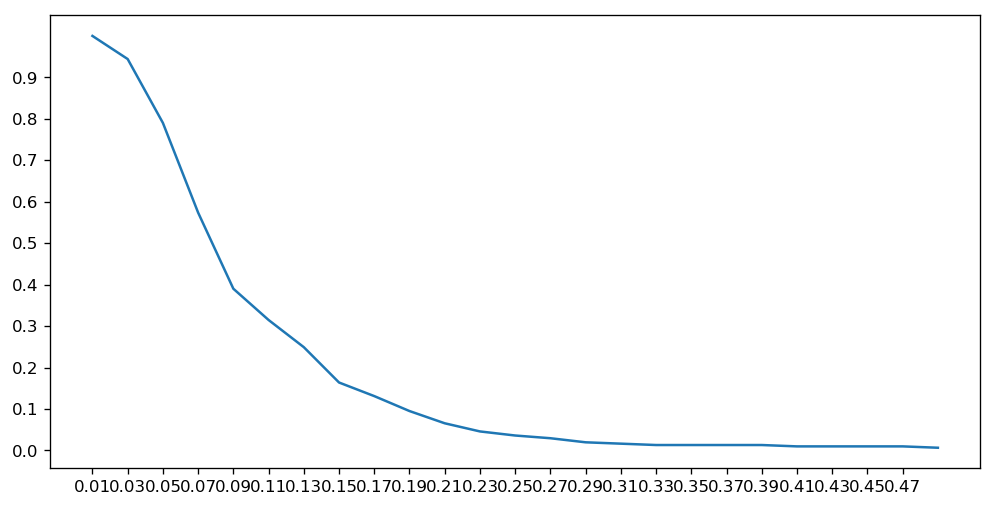

In [194]:
food_act_val = food_act['Act_value'].tolist()
food_act_val.count(0)
print (len(food_act_val))
print (food_act_val.count(0))

# Remove Zero occurance value from the list
def remove_value_from_list(the_list, val):
    return [value for value in the_list if value != val]

food_act_val = remove_value_from_list(food_act_val, 0)
print (len(food_act_val))

# Total word in the networks are 592
# Count for the 0.01 ,0.003
#sum(i > 5 for i in j)

x = np.arange(0.01, 0.50, 0.02)
print (x)
y = []
for i in x:
    #print (sum (k > i for k  in food_act_val ))
    y.append((sum (k > i for k  in food_act_val ))/ (len(food_act_val)))

print (y)

%matplotlib inline

plt.figure(num=None, figsize=(10, 5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(x, y)

plt.xticks(np.arange( 0.01 , max(x), 0.02))
plt.yticks(np.arange(0.0, 1, 0.1))


plt.show()



In [195]:
start_time = time.clock()
word_hi_act

for w_h_act in word_hi_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in word_hi_act:
    category_word = w_h_act
    
    for w in words:
        #print (w)
        Wij = W_dfinal.loc[category_word, w]
        Aj = (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (food_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        food_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)
    
    
#words.remove(category_word)


Time require in second  26.4504024457201


In [196]:
count = 0

ano_hi_word_act = []

for w in words:
    if (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.22:
        #print (w)
        word_hi_act.append(w)
        ano_hi_word_act.append(w)
        count += 1
        
    #elif (food_act.loc[word_data['Word']== w, 'Act_value'].iloc[0]) > 0:
        #count += 1
                #print (w)
        
print (count)


11


In [197]:
start_time = time.clock()
ano_hi_word_act

for w_h_act in ano_hi_word_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in ano_hi_word_act:
    category_word = w_h_act
    
    for w in words:
        #print (w)
        Wij = W_dfinal.loc[category_word, w]
        Aj = (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (food_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        food_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)



Time require in second  15.78457511635861


In [198]:
aano_hi_word_act = []
count = 0
for w in words:
    if (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.22:
        #print (w)
        word_hi_act.append(w)
        aano_hi_word_act.append(w)
        count += 1
        
    #elif (food_act.loc[word_data['Word']== w, 'Act_value'].iloc[0]) > 0:
        #count += 1
                #print (w)
        
print (count)

8


In [200]:
aano_hi_word_act
start_time = time.clock()
aano_hi_word_act

for w_h_act in aano_hi_word_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in aano_hi_word_act:
    category_word = w_h_act
    
    for w in words:
        #print (w)
        Wij = W_dfinal.loc[category_word, w]
        Aj = (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (food_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        food_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)


Time require in second  11.31196791723778


In [201]:
aaano_hi_word_act = []
count = 0
for w in words:
    if (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.22:
        #print (w)
        word_hi_act.append(w)
        aaano_hi_word_act.append(w)
        count += 1
        
    #elif (food_act.loc[word_data['Word']== w, 'Act_value'].iloc[0]) > 0:
        #count += 1
                #print (w)
        
print (count)

10


In [203]:
aaano_hi_word_act
start_time = time.clock()
aaano_hi_word_act

for w_h_act in aaano_hi_word_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in aaano_hi_word_act:
    category_word = w_h_act
    
    for w in words:
        #print (w)
        Wij = W_dfinal.loc[category_word, w]
        Aj = (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (food_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        food_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)


Time require in second  13.848088928059951


In [204]:
aaaano_hi_word_act = []
count = 0
for w in words:
    if (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.22:
        #print (w)
        word_hi_act.append(w)
        aaaano_hi_word_act.append(w)
        count += 1    
         
print (count)

4


In [205]:
aaaano_hi_word_act

['dish', 'good', 'east', 'day']

In [206]:
aaaano_hi_word_act
start_time = time.clock()
aaano_hi_word_act

for w_h_act in aaaano_hi_word_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in aaaano_hi_word_act:
    category_word = w_h_act
    
    for w in words:
        #print (w)
        Wij = W_dfinal.loc[category_word, w]
        Aj = (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (food_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        food_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)

Time require in second  5.457851604394818


In [208]:
aaaaano_hi_word_act = []
count = 0
for w in words:
    if (food_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.22:
        #print (w)
        word_hi_act.append(w)
        aaaaano_hi_word_act.append(w)
        count += 1    
         
print (count)

14


In [209]:
aaaaano_hi_word_act

['taste',
 'hot',
 'ca',
 'choice',
 'sometimes',
 'less',
 'decent',
 'fine',
 'part',
 'nothing',
 'large',
 'bistro',
 'bill',
 'share']

In [210]:
food_act

,Word,Act_value
0,staff,0.048325
1,horrible,0.484615
2,us,0.088721
3,food,1.000000
4,average,0.288000
5,could,0.128229
6,nt,0.146353
7,make,0.191514
8,feel,0.078536
9,like,0.127974


In [211]:
food_act

print (type(food_act))
food_act.columns



<class 'pandas.core.frame.DataFrame'>


Index(['Word', 'Act_value'], dtype='object')

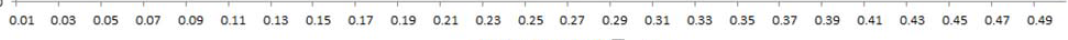

#### For Service Data

In [226]:
category_word = 'service'
service_act = copy.deepcopy(word_data)
service_act.loc[word_data['Word'] == 'service', 'Act_value'] =1


delt = 0.9

words = service_act['Word'].tolist()



words.remove(category_word)
       
for w in words:
    #print (w)
    Wij = W_dfinal.loc[category_word, w]
    Aj = (service_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
    Ai = (service_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
    a_val = min((Aj + Ai * Wij * delt ),1)
    service_act.loc[word_data['Word'] == w, 'Act_value'] = a_val
    
#print (words)
#print (food_act)
category_word = 'serve'
service_act.loc[word_data['Word'] == 'service', 'Act_value'] =1
words.remove(category_word)
for w in words:
    #print (w)
    Wij = W_dfinal.loc[category_word, w]
    Aj = (service_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
    Ai = (service_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
    a_val = min((Aj + Ai * Wij * delt ),1)
    service_act.loc[word_data['Word'] == w, 'Act_value'] = a_val



service_act.loc[word_data['Word'] == 'food', 'Act_value'] = 0
#food_act.loc[word_data['Word'] == 'serve', 'Act_value'] = 0
service_act.loc[word_data['Word'] == 'price', 'Act_value'] = 0
service_act.loc[word_data['Word'] == 'ambience', 'Act_value'] = 0
service_act.loc[word_data['Word'] == 'atomsphere', 'Act_value'] = 0
service_act.loc[word_data['Word'] == 'ambiance', 'Act_value'] = 0


print ("Finish")


Finish


In [227]:
ser_word_hi_act = []

count = 0
for w in words:
    if (service_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.15:
        #print (w)
        ser_word_hi_act.append(w)   
        count += 1
        
print (count)



19


405
174
231
[ 0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19  0.21  0.23
  0.25  0.27  0.29  0.31  0.33  0.35  0.37  0.39  0.41  0.43  0.45  0.47
  0.49]
[0.90476190476190477, 0.68398268398268403, 0.4935064935064935, 0.2857142857142857, 0.20779220779220781, 0.15151515151515152, 0.10822510822510822, 0.086580086580086577, 0.064935064935064929, 0.05627705627705628, 0.043290043290043288, 0.034632034632034632, 0.030303030303030304, 0.025974025974025976, 0.021645021645021644, 0.021645021645021644, 0.021645021645021644, 0.021645021645021644, 0.021645021645021644, 0.021645021645021644, 0.017316017316017316, 0.012987012987012988, 0.012987012987012988, 0.012987012987012988, 0.012987012987012988]


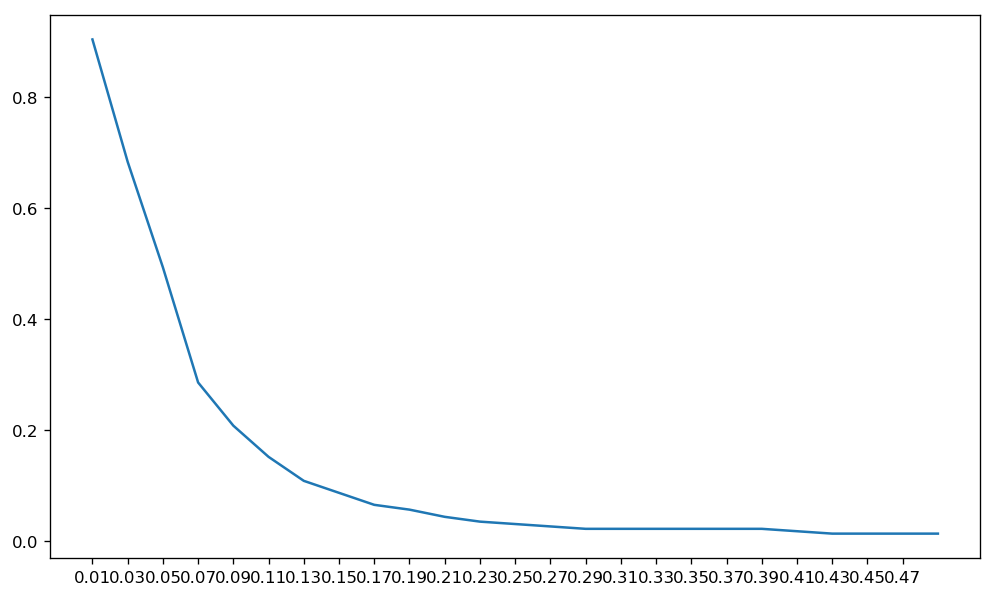

In [228]:
service_act_val = service_act['Act_value'].tolist()
service_act_val.count(0)
print (len(service_act_val))
print (service_act_val.count(0))

# Remove Zero occurance value from the list
def remove_value_from_list(the_list, val):
    return [value for value in the_list if value != val]

service_act_val = remove_value_from_list(service_act_val, 0)
print (len(service_act_val))

# Total word in the networks are 592
# Count for the 0.01 ,0.003
#sum(i > 5 for i in j)

x = np.arange(0.01, 0.50, 0.02)
print (x)
y = []
for i in x:
    #print (sum (k > i for k  in food_act_val ))
    y.append((sum (k > i for k  in service_act_val ))/ (len(service_act_val)))

print (y)

%matplotlib inline

plt.figure(num=None, figsize=(10, 6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(x, y)

plt.xticks(np.arange( 0.01 , max(x), 0.02))
plt.yticks(np.arange(0.0, 1, 0.2))


plt.show()


In [229]:

start_time = time.clock()
ser_word_hi_act 

for w_h_act in ser_word_hi_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in ser_word_hi_act:
    category_word = w_h_act
    for w in words:
        Wij = W_dfinal.loc[category_word, w]
        Aj = (service_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (service_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        service_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)


Time require in second  27.972319829527805


In [230]:
count = 0

aser_word_hi_act=[]

for w in words:
    if (service_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.19:
        aser_word_hi_act.append(w)
        print (w)
        count += 1 
print (count)

joint
server
2


In [231]:
start_time = time.clock()
ser_word_hi_act 

for w_h_act in aser_word_hi_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in aser_word_hi_act:
    category_word = w_h_act
    for w in words:
        Wij = W_dfinal.loc[category_word, w]
        Aj = (service_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (service_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        service_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)

Time require in second  2.923679639351576


In [233]:
count = 0
aaser_word_hi_act = []
for w in words:
    if (service_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.19:
        aaser_word_hi_act.append(w)
        print (w)
        count += 1 
print (count)




0


#### For ambience

In [141]:
word_data

,Word,Act_value
0,staff,0.0
1,horrible,0.0
2,us,0.0
3,food,0.0
4,average,0.0
5,could,0.0
6,nt,0.0
7,make,0.0
8,feel,0.0
9,like,0.0


In [234]:

delt = 0.9
def cal_act_val(category_word,category_act, words):
    for w in words:
    #print (w)
        Wij = W_dfinal.loc[category_word, w]
        Aj = (category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (category_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        category_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

        
        
category_word = 'ambience'
category_act = copy.deepcopy(word_data)
category_act.loc[word_data['Word']==category_word, 'Act_value'] = 1

words = category_act['Word'].tolist()
words.remove(category_word)
    
cal_act_val(category_word, category_act, words)

#.iloc[0] 

category_word = 'atmosphere'
category_act.loc[word_data['Word']==category_word, 'Act_value'] = 1
words.remove(category_word)
cal_act_val(category_word, category_act, words)

category_word = 'ambiance'
category_act.loc[word_data['Word']==category_word, 'Act_value'] = 1
words.remove(category_word)
cal_act_val(category_word, category_act, words)

print (type(words))

category_act.loc[word_data['Word'] == 'food', 'Act_value'] = 0

category_act.loc[word_data['Word'] == 'serve', 'Act_value'] = 0
category_act.loc[word_data['Word'] == 'price', 'Act_value'] = 0
category_act.loc[word_data['Word'] == 'service', 'Act_value'] = 0





    
#print (words)
#print (food_act)
print ("Finish")


<class 'list'>
Finish


In [235]:
count = 0

amb_word_hi_act =[]

for w in words:
    if (category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.09:
        amb_word_hi_act.append(w)
        count += 1
    
        
print (count)

9


405
269
136
[ 0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19  0.21  0.23
  0.25  0.27  0.29  0.31  0.33  0.35  0.37  0.39  0.41  0.43  0.45  0.47
  0.49]
[0.97058823529411764, 0.625, 0.38235294117647056, 0.18382352941176472, 0.088235294117647065, 0.080882352941176475, 0.080882352941176475, 0.066176470588235295, 0.044117647058823532, 0.029411764705882353, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766, 0.022058823529411766]


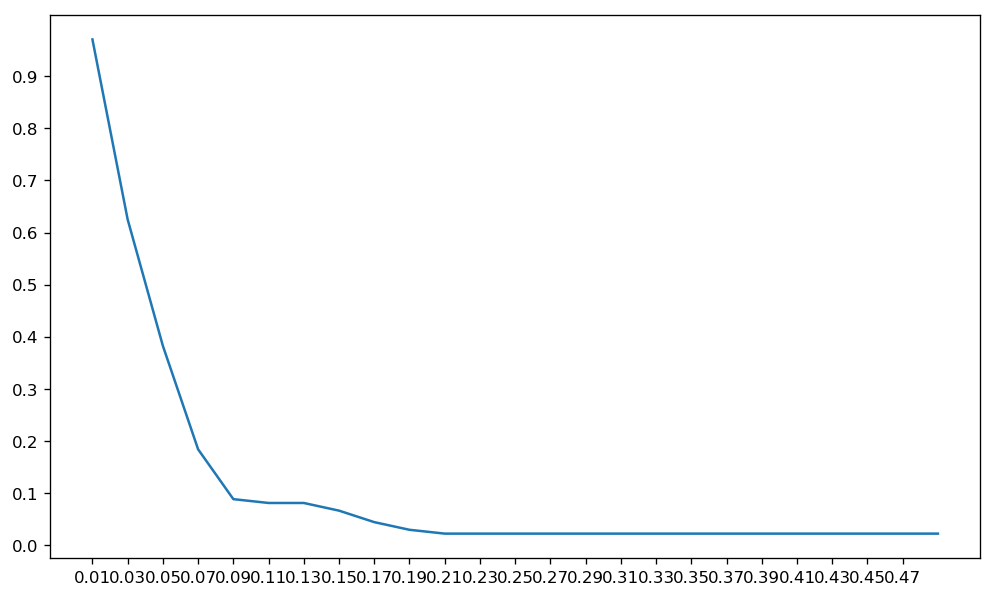

In [236]:





service_act_val = category_act['Act_value'].tolist()
service_act_val.count(0)
print (len(service_act_val))
print (service_act_val.count(0))

# Remove Zero occurance value from the list
def remove_value_from_list(the_list, val):
    return [value for value in the_list if value != val]

service_act_val = remove_value_from_list(service_act_val, 0)
print (len(service_act_val))

# Total word in the networks are 592
# Count for the 0.01 ,0.003
#sum(i > 5 for i in j)

x = np.arange(0.01, 0.50, 0.02)
print (x)
y = []
for i in x:
    #print (sum (k > i for k  in food_act_val ))
    y.append((sum (k > i for k  in service_act_val ))/ (len(service_act_val)))

print (y)

%matplotlib inline

plt.figure(num=None, figsize=(10, 6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(x, y)

plt.xticks(np.arange( 0.01 , max(x), 0.02))
plt.yticks(np.arange(0.0, 1, 0.1))


plt.show()



In [237]:
start_time = time.clock()
amb_word_hi_act 

for w_h_act in amb_word_hi_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in amb_word_hi_act:
    category_word = w_h_act
    for w in words:
        Wij = W_dfinal.loc[category_word, w]
        Aj = (category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (category_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        category_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)

Time require in second  13.51994813235433


In [239]:
count = 0
aamb_word_hi_act = []
for w in words:
    if (category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.09:
        aamb_word_hi_act.append(w)
        print (w)
        count += 1
        
            
print (count)

crowd
trip
sweet
3


In [240]:
start_time = time.clock()
 

for w_h_act in aamb_word_hi_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in aamb_word_hi_act:
    category_word = w_h_act
    for w in words:
        Wij = W_dfinal.loc[category_word, w]
        Aj = (category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (category_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        category_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)

Time require in second  4.50747385449904


In [241]:
count = 0
aaamb_word_hi_act = []
for w in words:
    if (category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.09:
        aaamb_word_hi_act.append(w)
        print (w)
        count += 1
        
            
print (count)

0


In [155]:
word_data
words = price_category_act['Word'].tolist()
words.remove('us')
words

['staff',
 'horrible',
 'food',
 'average',
 'could',
 'nt',
 'make',
 'feel',
 'like',
 'menu',
 'recommend',
 'eat',
 'go',
 'enjoy',
 'say',
 'get',
 'outstanding',
 'little',
 'great',
 'tasty',
 'favorite',
 'chicken',
 'usually',
 'waiter',
 'kind',
 'enough',
 'dish',
 'half',
 'taste',
 'terrific',
 'yet',
 'pretty',
 'good',
 'st',
 'forget',
 'leave',
 'ingredient',
 'cheese',
 'hot',
 'cook',
 'plate',
 'take',
 'hour',
 'check',
 'perfect',
 'since',
 'sit',
 'drink',
 'atmosphere',
 'visit',
 'quite',
 'cuisine',
 'would',
 'definitely',
 'one',
 'regular',
 'neighborhood',
 'pizza',
 'best',
 'girlfriend',
 'place',
 'night',
 'time',
 'ca',
 'fast',
 'upper',
 'east',
 'side',
 'run',
 'know',
 'special',
 'really',
 'back',
 'money',
 'chef',
 'seat',
 'ask',
 'even',
 'two',
 'people',
 'whole',
 'experience',
 'selection',
 'seafood',
 'family',
 'want',
 'try',
 'warm',
 'owner',
 'friendly',
 'service',
 'value',
 'joint',
 'delivery',
 'incredible',
 'spot',
 'reas

In [242]:
# For the price Data


delt = 0.9
def cal_act_val(category_word,price_category_act, words):
    for w in words:
    #print (w)
        Wij = W_dfinal.loc[category_word, w]
        Aj = (price_category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (price_category_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        price_category_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

        
        
category_word = 'price'
price_category_act = copy.deepcopy(word_data)
price_category_act.loc[word_data['Word']==category_word, 'Act_value'] = 1
words = price_category_act['Word'].tolist()

words.remove(category_word)
    
cal_act_val(category_word, price_category_act, words)

#.iloc[0] 





print (type(words))

price_category_act.loc[word_data['Word'] == 'food', 'Act_value'] = 0

price_category_act.loc[word_data['Word'] == 'service', 'Act_value'] = 0
price_category_act.loc[word_data['Word'] == 'ambience', 'Act_value'] = 0
price_category_act.loc[word_data['Word'] == 'serve', 'Act_value'] = 0

price_category_act.loc[word_data['Word'] == 'atomsphere', 'Act_value'] = 0
price_category_act.loc[word_data['Word'] == 'ambiance', 'Act_value'] = 0

print("Finish")
    
#print (words)
#print (food_act)




<class 'list'>
Finish


In [243]:
count = 0

price_word_hi_act =[]

for w in words:
    if (price_category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.09:
        price_word_hi_act.append(w)
        count += 1
        
print (count)

12


405
293
112
[ 0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19  0.21  0.23
  0.25  0.27  0.29  0.31  0.33  0.35  0.37  0.39  0.41  0.43  0.45  0.47
  0.49]
[0.9821428571428571, 0.6607142857142857, 0.45535714285714285, 0.16964285714285715, 0.11607142857142858, 0.089285714285714288, 0.071428571428571425, 0.035714285714285712, 0.026785714285714284, 0.026785714285714284, 0.026785714285714284, 0.026785714285714284, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.017857142857142856, 0.0089285714285714281, 0.0089285714285714281, 0.0089285714285714281, 0.0089285714285714281, 0.0089285714285714281, 0.0089285714285714281, 0.0089285714285714281]


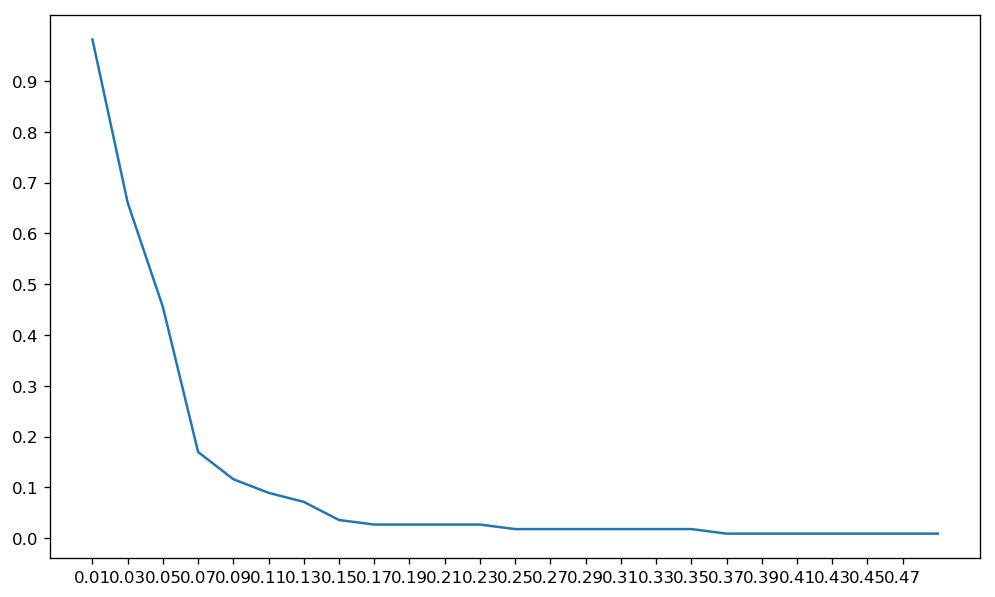

In [244]:

service_act_val = price_category_act['Act_value'].tolist()
price_category_act.count(0)
print (len(service_act_val))
print (service_act_val.count(0))

# Remove Zero occurance value from the list
def remove_value_from_list(the_list, val):
    return [value for value in the_list if value != val]

service_act_val = remove_value_from_list(service_act_val, 0)
print (len(service_act_val))

# Total word in the networks are 592
# Count for the 0.01 ,0.003
#sum(i > 5 for i in j)

x = np.arange(0.01, 0.50, 0.02)
print (x)
y = []
for i in x:
    #print (sum (k > i for k  in food_act_val ))
    y.append((sum (k > i for k  in service_act_val ))/ (len(service_act_val)))

print (y)

%matplotlib inline

plt.figure(num=None, figsize=(10, 6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(x, y)

plt.xticks(np.arange( 0.01 , max(x), 0.02))
plt.yticks(np.arange(0.0, 1, 0.1))


plt.show()

In [245]:
start_time = time.clock()
price_word_hi_act 

for w_h_act in price_word_hi_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in price_word_hi_act:
    category_word = w_h_act
    for w in words:
        Wij = W_dfinal.loc[category_word, w]
        Aj = (price_category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (price_category_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        price_category_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)

Time require in second  18.07398516197827


In [247]:
count = 0
aprice_word_hi_act  = []
for w in words:
    if (price_category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.09:
        aprice_word_hi_act.append(w)
        print (w)
        count += 1
        
            
print (count)

value
area
2


In [248]:
start_time = time.clock()
aprice_word_hi_act 

for w_h_act in aprice_word_hi_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in aprice_word_hi_act:
    category_word = w_h_act
    for w in words:
        Wij = W_dfinal.loc[category_word, w]
        Aj = (price_category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (price_category_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        price_category_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)

Time require in second  3.029487776529095


In [249]:
count = 0
aaprice_word_hi_act  = []
for w in words:
    if (price_category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.09:
        aaprice_word_hi_act.append(w)
        print (w)
        count += 1
        
            
print (count)

deli
extremely
2


In [250]:
start_time = time.clock()
aaprice_word_hi_act 

for w_h_act in aaprice_word_hi_act:
    category_word = w_h_act
    words.remove(category_word)

for w_h_act in aaprice_word_hi_act:
    category_word = w_h_act
    for w in words:
        Wij = W_dfinal.loc[category_word, w]
        Aj = (price_category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0])
        Ai = (price_category_act.loc[word_data['Word'] == category_word, 'Act_value'].iloc[0])
        a_val = min((Aj + Ai * Wij * delt ),1)
        price_category_act.loc[word_data['Word'] == w, 'Act_value'] = a_val

print ("Time require in second ", time.clock() - start_time)

Time require in second  2.996915587747935


In [251]:
count = 0
aaaprice_word_hi_act  = []
for w in words:
    if (price_category_act.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > 0.09:
        aaprice_word_hi_act.append(w)
        print (w)
        count += 1
        
            
print (count)

0


In [252]:
#store the Result of activation value Rule matrix Activation Matrix
# Names of the varibles for
# 1. Food =food_act     Thresold = 0.22
# 2. Service Word = service_act  = 0.19
# 3. Ambience Word = category_act = 0.09
# 4. Price Word = price_category_act = 0.09
cnt = 0
food_act 
for f in food_act:
    print (f)
    cnt += 1
print (cnt)
# print (food_act)
print (len(food_act))
print (type(food_act))

food_act.to_pickle('pickels/80k_food_act')
service_act.to_pickle('pickels/80k_service_act')
category_act.to_pickle('pickels/80k_ambience_act')

price_category_act.to_pickle('pickels/80k_price_act')



Word
Act_value
2
405
<class 'pandas.core.frame.DataFrame'>


In [253]:
# Find the words whose activation value is greater than threshold



print("Earlier", len(words))
def fetch_words(category,threshold, count):
    act_word = copy.deepcopy(word_data)
    words = act_word['Word'].tolist()
    new_words = []
    for w in words:
        if (category.loc[word_data['Word'] == w, 'Act_value'].iloc[0]) > threshold:
            new_words.append(w)
            count = count + 1
    return new_words, count
            #fetch_words(food_act, 0.22)


print(count)

print (len(words))






Earlier 388
0
388


In [254]:
count = 0
food_words = []
#my_i, my_card = select_choice()
food_words1, count = fetch_words(food_act, 0.22, count)
food_words = food_words1
print (count)
print (len(food_words))

66
66


In [255]:
count = 0
#my_i, my_card = select_choice()
service_words = []
service_words1, count = fetch_words(service_act, 0.19, count)
service_words = service_words1
print (count)
print (len(service_words))

15
15


In [256]:
count = 0
#my_i, my_card = select_choice()
ambience_words = []
ambience_words1, count = fetch_words(category_act, 0.09, count)
ambience_words = ambience_words1
print (count)
print (len(ambience_words))

15
15


In [257]:
count = 0
#my_i, my_card = select_choice()
price_words = []
price_words1, count = fetch_words(price_category_act, 0.09, count)
price_words = price_words1
print (count)
print (len(price_words))

17
17


In [258]:
service_words

['horrible',
 'outstanding',
 'fast',
 'friendly',
 'service',
 'joint',
 'prompt',
 'pleasant',
 'sometimes',
 'rush',
 'server',
 'quick',
 'attentive',
 'slow',
 'lack']

### Co-occurance Matrix in Python

#### Assign Aspect Categories
In the last step we predict categories for each unprocessed sentence, using the rule set R obtained from the previous step.



In [259]:
# Read data for the testing.
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
test_xml_data1 = open('D:\ABSA\Aspect_Based_Sentiment\semeval_data\Restaurants_Test_Data_phaseB.xml').read()

                                                        # Fetch the sentence data

test_xml_data = io.StringIO(test_xml_data1)
test_etree = ET.parse(test_xml_data) #create an ElementTree object 
test_doc_df = pd.DataFrame(list(iter_docs(test_etree.getroot())))

test_sentence_data = xml2df(test_xml_data1)

print(test_doc_df)

print(test_sentence_data) 

                     id
0     32897564#894393#2
1     33070600#670328#0
2     33070600#670328#2
3     36244464#949326#5
4     32894246#870052#0
5     32894246#870052#1
6     32894246#870052#2
7     35390182#756337#4
8     35390182#756337#5
9     11447227#436718#3
10   33071731#1007204#3
11    33085939#758010#0
12    11313431#524365#3
13   11359717#1138929#1
14   11359717#1138929#3
15   11359717#1138929#4
16    11313439#692431#0
17    11351513#832512#0
18    35390148#588852#2
19    11351513#832512#1
20    11313431#524365#2
21    35196520#758440#4
22    35196527#481646#2
23    35668126#536759#0
24    35668126#536759#1
25    35668126#536759#2
26   33070286#1133164#0
27   33070286#1133164#4
28   33070286#1133164#6
29    32894336#662479#0
..                  ...
770   35160930#774531#0
771   33085669#409731#2
772   11351628#404492#8
773   32896473#439063#0
774   11464511#471981#1
775   32899282#556036#1
776  32894966#1727613#3
777   32464601#418474#0
778   11432442#650772#2
779  11313290#11

In [260]:




test_aspect_category_records = []
for node in test_etree.iter():
    record = {} 
    #print(node.attrib)
    #print(node.tag)
    
    
    if(node.tag == 'sentence'):
        id = node.attrib.get('id')
        #print("1:",id)
        
    if(node.tag == 'aspectCategory' ):
        
        #print("2",id)
        record['id'] = id
        record['category'] = node.attrib.get('category')
        
        test_aspect_category_records.append(record)

In [261]:
test_aspect_category_records

[{'category': 'food', 'id': '32897564#894393#2'},
 {'category': 'service', 'id': '33070600#670328#0'},
 {'category': 'food', 'id': '33070600#670328#2'},
 {'category': 'food', 'id': '36244464#949326#5'},
 {'category': 'food', 'id': '32894246#870052#0'},
 {'category': 'ambience', 'id': '32894246#870052#0'},
 {'category': 'anecdotes/miscellaneous', 'id': '32894246#870052#1'},
 {'category': 'food', 'id': '32894246#870052#2'},
 {'category': 'food', 'id': '35390182#756337#4'},
 {'category': 'food', 'id': '35390182#756337#5'},
 {'category': 'food', 'id': '11447227#436718#3'},
 {'category': 'food', 'id': '33071731#1007204#3'},
 {'category': 'food', 'id': '33085939#758010#0'},
 {'category': 'service', 'id': '33085939#758010#0'},
 {'category': 'food', 'id': '11313431#524365#3'},
 {'category': 'ambience', 'id': '11313431#524365#3'},
 {'category': 'service', 'id': '11359717#1138929#1'},
 {'category': 'food', 'id': '11359717#1138929#3'},
 {'category': 'food', 'id': '11359717#1138929#4'},
 {'categor

In [262]:
test_aspect_category = pd.DataFrame(test_aspect_category_records)
test_aspect_category

,category,id
0,food,32897564#894393#2
1,service,33070600#670328#0
2,food,33070600#670328#2
3,food,36244464#949326#5
4,food,32894246#870052#0
5,ambience,32894246#870052#0
6,anecdotes/miscellaneous,32894246#870052#1
7,food,32894246#870052#2
8,food,35390182#756337#4
9,food,35390182#756337#5


In [263]:
test_text_data = pd.concat([test_doc_df, test_sentence_data], axis=1)
test_text_data

,id,text
0,32897564#894393#2,The bread is top notch as well.
1,33070600#670328#0,I have to say they have one of the fastest del...
2,33070600#670328#2,Food is always fresh and hot- ready to eat!
3,36244464#949326#5,Did I mention that the coffee is OUTSTANDING?
4,32894246#870052#0,"Certainly not the best sushi in New York, howe..."
5,32894246#870052#1,"I trust the people at Go Sushi, it never disap..."
6,32894246#870052#2,"Straight-forward, no surprises, very decent Ja..."
7,35390182#756337#4,"BEST spicy tuna roll, great asian salad."
8,35390182#756337#5,Try the rose roll (not on menu).
9,11447227#436718#3,"I love the drinks, esp lychee martini, and the..."


In [264]:
from nltk.corpus import wordnet
emmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [265]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [266]:
text = word_tokenize("It is better.")
print ("Tokenized Text", text)
print(len(word_tokenize("It is better.")))

a = nltk.pos_tag(text)
def nlp_test_lemmatizing(total_text, index, column):
    if(total_text) is not int:
        string = ""
        total_text= word_tokenize(total_text)
        a = nltk.pos_tag(total_text)
        print ('a: ', a)
        for w in a:
            try:
                string += lemmatizer.lemmatize(w[0],get_wordnet_pos(w[1])) +" "
            except:
                string += w[0] + " "
    test_text_data[column][index] = string

Tokenized Text ['It', 'is', 'better', '.']
4


In [267]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in test_text_data.iterrows():
    nlp_test_lemmatizing(row['text'], index, 'text')

# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

a:  [('The', 'DT'), ('bread', 'NN'), ('is', 'VBZ'), ('top', 'JJ'), ('notch', 'NN'), ('as', 'RB'), ('well', 'RB'), ('.', '.')]
a:  [('I', 'PRP'), ('have', 'VBP'), ('to', 'TO'), ('say', 'VB'), ('they', 'PRP'), ('have', 'VBP'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('fastest', 'JJS'), ('delivery', 'NN'), ('times', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('city', 'NN'), ('.', '.')]
a:  [('Food', 'NN'), ('is', 'VBZ'), ('always', 'RB'), ('fresh', 'JJ'), ('and', 'CC'), ('hot-', 'JJ'), ('ready', 'NN'), ('to', 'TO'), ('eat', 'VB'), ('!', '.')]
a:  [('Did', 'NNP'), ('I', 'PRP'), ('mention', 'NN'), ('that', 'IN'), ('the', 'DT'), ('coffee', 'NN'), ('is', 'VBZ'), ('OUTSTANDING', 'VBN'), ('?', '.')]
a:  [('Certainly', 'RB'), ('not', 'RB'), ('the', 'DT'), ('best', 'JJS'), ('sushi', 'NN'), ('in', 'IN'), ('New', 'NNP'), ('York', 'NNP'), (',', ','), ('however', 'RB'), (',', ','), ('it', 'PRP'), ('is', 'VBZ'), ('always', 'RB'), ('fresh', 'JJ'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('place', 'NN')

a:  [('The', 'DT'), ('selection', 'NN'), ('of', 'IN'), ('food', 'NN'), ('is', 'VBZ'), ('excellent', 'JJ'), ('(', '('), ('I', 'PRP'), ("'m", 'VBP'), ('not', 'RB'), ('used', 'VBN'), ('to', 'TO'), ('having', 'VBG'), ('much', 'JJ'), ('choice', 'NN'), ('at', 'IN'), ('restaurants', 'NNS'), (')', ')'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('atmosphere', 'NN'), ('is', 'VBZ'), ('great', 'JJ'), ('.', '.')]
a:  [('Only', 'RB'), ('suggestion', 'NN'), ('is', 'VBZ'), ('that', 'IN'), ('you', 'PRP'), ('skip', 'VBP'), ('the', 'DT'), ('dessert', 'NN'), (',', ','), ('it', 'PRP'), ('was', 'VBD'), ('overpriced', 'VBN'), ('and', 'CC'), ('fell', 'VBD'), ('short', 'RB'), ('on', 'IN'), ('taste', 'NN'), ('.', '.')]
a:  [('Food', 'NN'), ('was', 'VBD'), ('decent', 'JJ'), (',', ','), ('but', 'CC'), ('not', 'RB'), ('great', 'JJ'), ('.', '.')]
a:  [('I', 'PRP'), ('have', 'VBP'), ('no', 'DT'), ('idea', 'NN'), ('why', 'WRB'), ('this', 'DT'), ('restaurant', 'NN'), ('is', 'VBZ'), ('so', 'RB'), ('often', 'RB'), ('ov

a:  [('And', 'CC'), ('as', 'RB'), ('SOON', 'NNP'), ('as', 'IN'), ('one', 'CD'), ('person', 'NN'), ('is', 'VBZ'), ('done', 'VBN'), (',', ','), ('she', 'PRP'), ('asked', 'VBD'), ('to', 'TO'), ('pick', 'VB'), ('up', 'RP'), ('the', 'DT'), ('plate', 'NN'), ('immediately', 'RB'), ('.', '.')]
a:  [('This', 'DT'), ('place', 'NN'), ('is', 'VBZ'), ('Italian', 'JJ'), (',', ','), ('not', 'RB'), ('French', 'JJ'), ('.', '.')]
a:  [('After', 'IN'), ('so', 'RB'), ('many', 'JJ'), ('great', 'JJ'), ('reviews', 'NNS'), ('here', 'RB'), (',', ','), ('my', 'PRP$'), ('bf', 'NN'), ('and', 'CC'), ('I', 'PRP'), ('went', 'VBD'), ('to', 'TO'), ('Esca', 'NNP'), ('to', 'TO'), ('celebrate', 'VB'), ('my', 'PRP$'), ('birthday', 'NN'), ('last', 'JJ'), ('nite', 'NN'), ('.', '.')]
a:  [('While', 'IN'), ('their', 'PRP$'), ('kitchen', 'NN'), ('food', 'NN'), ('is', 'VBZ'), ('delicious', 'JJ'), (',', ','), ('their', 'PRP$'), ('Sushi', 'NNP'), ('is', 'VBZ'), ('out', 'IN'), ('of', 'IN'), ('this', 'DT'), ('world', 'NN'), ('.', '

a:  [('Another', 'DT'), ('great', 'JJ'), ('thing', 'NN'), ('about', 'IN'), ('Glechik-everything', 'NNP'), ('is', 'VBZ'), ('very', 'RB'), ('cheap', 'JJ'), ('!', '.')]
a:  [('Unfortunately', 'RB'), (',', ','), ('we', 'PRP'), ('chose', 'VBD'), ('this', 'DT'), ('spot', 'NN'), ('for', 'IN'), ('lunch', 'NN'), ('as', 'IN'), ('we', 'PRP'), ('had', 'VBD'), ('done', 'VBN'), ('a', 'DT'), ('lot', 'NN'), ('of', 'IN'), ('walking', 'VBG'), ('and', 'CC'), ('ended', 'VBD'), ('up', 'RB'), ('at', 'IN'), ('the', 'DT'), ('South', 'NNP'), ('St', 'NNP'), ('Seaport', 'NNP'), ('.', '.')]
a:  [('But', 'CC'), ('regulars', 'NNS'), ('know', 'VBP'), ('that', 'IN'), ('the', 'DT'), ('sandwiches', 'NNS'), ('are', 'VBP'), ('the', 'DT'), ('real', 'JJ'), ('star', 'NN'), ('here', 'RB'), ('.', '.')]
a:  [('The', 'DT'), ('skillfully', 'RB'), ('chosen', 'VBN'), ('Portuguese', 'JJ'), ('cheese', 'JJ'), ('cart', 'NN'), ('paired', 'VBN'), ('with', 'IN'), ('quality', 'NN'), ('port', 'NN'), ('provides', 'VBZ'), ('the', 'DT'), ('pe

a:  [('Not', 'RB'), ('only', 'RB'), ('did', 'VBD'), ('they', 'PRP'), ('have', 'VBP'), ('amazing', 'VBG'), (',', ','), ('sandwiches', 'NNS'), (',', ','), ('soup', 'NN'), (',', ','), ('pizza', 'NN'), ('etc', 'NN'), (',', ','), ('but', 'CC'), ('their', 'PRP$'), ('homemade', 'JJ'), ('sorbets', 'NNS'), ('are', 'VBP'), ('out', 'IN'), ('of', 'IN'), ('this', 'DT'), ('world', 'NN'), ('!', '.')]
a:  [('the', 'DT'), ('homemade', 'NN'), ('Guacamole', 'NNP'), (',', ','), ('the', 'DT'), ('unbelievable', 'JJ'), ('entree', 'NN'), (',', ','), ('and', 'CC'), ('thee', 'VBZ'), ('most', 'RBS'), ('amazing', 'JJ'), ('deserts', 'NNS'), ('.', '.')]
a:  [('The', 'DT'), ('sushi', 'NN'), ('is', 'VBZ'), ('reasonably', 'RB'), ('priced', 'VBN'), ('and', 'CC'), ('fresh', 'JJ'), ('.', '.')]
a:  [('It', 'PRP'), ("'s", 'VBZ'), ('no-fuss', 'JJ'), (',', ','), ('fast', 'JJ'), ('and', 'CC'), ('delicious', 'JJ'), ('.', '.')]
a:  [('Save', 'NNP'), ('room', 'NN'), ('for', 'IN'), ('deserts', 'NNS'), ('-', ':'), ('they', 'PRP'),

a:  [('The', 'DT'), ('staff', 'NN'), ('is', 'VBZ'), ('100', 'CD'), ('%', 'NN'), ('Italian', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('as', 'RB'), ('authentic', 'JJ'), ('as', 'IN'), ('it', 'PRP'), ('gets', 'VBZ'), ('.', '.')]
a:  [('My', 'PRP$'), ('only', 'JJ'), ('complaint', 'NN'), ('might', 'MD'), ('be', 'VB'), ('the', 'DT'), ('fortune', 'NN'), ('cookies', 'VBZ'), ('-', ':'), ('I', 'PRP'), ("'ve", 'VBP'), ('never', 'RB'), ('had', 'VBD'), ('a', 'DT'), ('cookie', 'NN'), ('predict', 'NN'), ('bad', 'JJ'), ('luck', 'NN'), ('for', 'IN'), ('me', 'PRP'), ('before', 'IN'), ('I', 'PRP'), ('visited', 'VBD'), ('Kar', 'NNP'), ('.', '.')]
a:  [('Good', 'JJ'), ('for', 'IN'), ('a', 'DT'), ('quick', 'JJ'), ('sushi', 'NN'), ('lunch', 'NN'), ('.', '.')]
a:  [('Have', 'VBP'), ('a', 'DT'), ('mojito', 'NN'), ('and', 'CC'), ('sit', 'NN'), ('in', 'IN'), ('the', 'DT'), ('back', 'JJ'), ('patio', 'NN'), ('.', '.')]
a:  [('The', 'DT'), ('service', 'NN'), ('was', 'VBD'), ('dreadfully',

a:  [('I', 'PRP'), ('got', 'VBD'), ('the', 'DT'), ('opportunity', 'NN'), ('to', 'TO'), ('dine', 'VB'), ('at', 'IN'), ('your', 'PRP$'), ('establishment', 'NN'), ('again', 'RB'), ('a', 'DT'), ('few', 'JJ'), ('weeks', 'NNS'), ('ago', 'RB'), (',', ','), ('I', 'PRP'), ('was', 'VBD'), ('in', 'IN'), ('your', 'PRP$'), ('upstrairs', 'JJ'), ('dining', 'JJ'), ('area', 'NN'), ('.', '.')]
a:  [('Meat-phobes', 'NNS'), ('are', 'VBP'), ('in', 'IN'), ('luck', 'NN'), ('with', 'IN'), ('the', 'DT'), ('extraordinary', 'JJ'), ('veggie', 'NN'), ('burger', 'NN'), (',', ','), ('made', 'VBN'), ('from', 'IN'), ('a', 'DT'), ('distinctive', 'JJ'), ('blend', 'NN'), ('of', 'IN'), ('chickpeas', 'NNS'), (',', ','), ('carrots', 'NNS'), ('and', 'CC'), ('other', 'JJ'), ('vegetables', 'NNS'), ('and', 'CC'), ('spices', 'NNS'), ('.', '.')]
a:  [('At', 'IN'), ('peak', 'JJ'), ('times', 'NNS'), (',', ','), ('the', 'DT'), ('restaurant', 'NN'), ('is', 'VBZ'), ('overcrowded', 'VBN'), ('and', 'CC'), ('tables', 'NNS'), ('are', 'VBP

a:  [('The', 'DT'), ('restaurant', 'NN'), ('could', 'MD'), ('use', 'VB'), ('a', 'DT'), ('little', 'JJ'), ('paint', 'NN'), (',', ','), ('but', 'CC'), ('all', 'DT'), ('in', 'IN'), ('all', 'PDT'), ('a', 'DT'), ('great', 'JJ'), ('sushi', 'JJ'), ('place', 'NN'), ('!', '.')]
a:  [('Make', 'NNP'), ('more', 'JJR'), ('tables-', 'JJ'), ('perhaps', 'RB'), ('a', 'DT'), ('rooftop', 'NN'), ('bar', 'NN'), ('?', '.')]
a:  [('The', 'DT'), ('decoration', 'NN'), ('was', 'VBD'), ('feeling', 'VBG'), ('like', 'IN'), ('we', 'PRP'), ('was', 'VBD'), ('on', 'IN'), ('the', 'DT'), ('Cairo', 'NNP'), (',', ','), ('actually', 'RB'), ('the', 'DT'), ('street', 'NN'), ('is', 'VBZ'), ('part', 'NN'), ('of', 'IN'), ('that', 'DT'), ('adventure', 'NN'), ('.', '.')]
a:  [('Although', 'IN'), ('small', 'JJ'), (',', ','), ('it', 'PRP'), ('has', 'VBZ'), ('beautiful', 'JJ'), ('ambience', 'NN'), (',', ','), ('excellent', 'JJ'), ('food', 'NN'), ('(', '('), ('the', 'DT'), ('catfish', 'NN'), ('is', 'VBZ'), ('delicious', 'JJ'), ('-', 

In [268]:
test_text_data

,id,text
0,32897564#894393#2,The bread be top notch as well .
1,33070600#670328#0,I have to say they have one of the fast delive...
2,33070600#670328#2,Food be always fresh and hot- ready to eat !
3,36244464#949326#5,Did I mention that the coffee be OUTSTANDING ?
4,32894246#870052#0,"Certainly not the best sushi in New York , how..."
5,32894246#870052#1,"I trust the people at Go Sushi , it never disa..."
6,32894246#870052#2,"Straight-forward , no surprise , very decent J..."
7,35390182#756337#4,"BEST spicy tuna roll , great asian salad ."
8,35390182#756337#5,Try the rise roll ( not on menu ) .
9,11447227#436718#3,"I love the drink , esp lychee martini , and th..."


In [269]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)


def nlp_test_stopwordRemove(total_text, index, column):
    #print(total_text)
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ''.join(e for e in words if e.isalnum())
            word = word.lower()
            # Remove stop words
            if not word in stop_words:
                string += word + " "
    test_text_data[column][index] = string

list of stop words: {'wouldn', 'her', 'most', 'into', 'him', 'has', 'over', 'having', 'why', 'nor', 'ourselves', 've', 'other', 't', 'their', 'during', 'some', 'such', 'only', 'our', 'once', 'against', 'the', 'after', 'herself', 'mightn', 'his', 'these', 'but', 'd', 'a', 'shouldn', 'its', 'in', 'up', 'yourselves', 'just', 'm', 'hadn', 'off', 'each', 'from', 's', 'needn', 'under', 'same', 'being', 'how', 'yours', 'weren', 'didn', 'on', 'when', 'yourself', 'that', 'she', 'what', 'are', 'theirs', 'no', 'own', 'they', 'because', 'between', 'further', 'haven', 're', 'all', 'o', 'you', 'hers', 'should', 'to', 'below', 'here', 'until', 'll', 'were', 'not', 'mustn', 'have', 'am', 'with', 'themselves', 'few', 'y', 'he', 'than', 'will', 'whom', 'so', 'i', 'doesn', 'more', 'at', 'this', 'them', 'was', 'had', 'for', 'above', 'be', 'aren', 'my', 'down', 'do', 'ours', 'we', 'too', 'wasn', 'as', 'then', 'did', 'and', 'your', 'there', 'by', 'ain', 'me', 'through', 'if', 'it', 'both', 'out', 'is', 'sha

In [270]:

start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in test_text_data.iterrows():
    nlp_test_stopwordRemove(row['text'], index, 'text')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")



0.15517637308767007 seconds


In [271]:
test_text_data

,id,text
0,32897564#894393#2,bread top notch well
1,33070600#670328#0,say one fast delivery time city
2,33070600#670328#2,food always fresh hot ready eat
3,36244464#949326#5,mention coffee outstanding
4,32894246#870052#0,certainly best sushi new york however always...
5,32894246#870052#1,trust people go sushi never disappoints
6,32894246#870052#2,straightforward surprise decent japanese food
7,35390182#756337#4,best spicy tuna roll great asian salad
8,35390182#756337#5,try rise roll menu
9,11447227#436718#3,love drink esp lychee martini food also good


In [272]:
service_words 
food_words 

['horrible',
 'food',
 'average',
 'outstanding',
 'tasty',
 'dish',
 'taste',
 'pretty',
 'good',
 'hot',
 'cook',
 'plate',
 'atmosphere',
 'quite',
 'cuisine',
 'ca',
 'upper',
 'east',
 'side',
 'reasonable',
 'evening',
 'choice',
 'include',
 'delicious',
 'steak',
 'world',
 'pricey',
 'size',
 'day',
 'sometimes',
 'rush',
 'well',
 'authentic',
 'less',
 'decent',
 'fine',
 'consider',
 'tiny',
 'bland',
 'cheap',
 'fresh',
 'part',
 'nothing',
 'person',
 'large',
 'door',
 'rather',
 'especially',
 'sauce',
 'ok',
 'amazing',
 'slightly',
 'portion',
 'quality',
 'absolutely',
 'bistro',
 'spicy',
 'spend',
 'expensive',
 'flavor',
 'bill',
 'cold',
 'lamb',
 'share',
 'sweet',
 'extremely']

Test With the R words

In [273]:
type(service_words)

list

Lemmatization of the test data

In [187]:
test_text_data

,id,text
0,32897564#894393#2,bread top notch well
1,33070600#670328#0,say one fast delivery time city
2,33070600#670328#2,food always fresh hot ready eat
3,36244464#949326#5,mention coffee outstanding
4,32894246#870052#0,certainly best sushi new york however always...
5,32894246#870052#1,trust people go sushi never disappoints
6,32894246#870052#2,straightforward surprise decent japanese food
7,35390182#756337#4,best spicy tuna roll great asian salad
8,35390182#756337#5,try rise roll menu
9,11447227#436718#3,love drink esp lychee martini food also good


In [274]:
test_aspect_category

test_aspect_category['category']

print(type(test_aspect_category))

#co = test_aspect_category.groupby('id').receipt.count()
#print (co)
c = len(test_aspect_category.loc[test_aspect_category['id'] == '32894246#870052#0', 'category'])
print (c)
print (type(c))
category_type_origin = set() 
for i in np.arange(c):
    print (i)
    print (test_aspect_category.loc[test_aspect_category['id'] == '32894246#870052#0', 'category'].iloc[i])
    category_type_origin.add(test_aspect_category.loc[test_aspect_category['id'] == '32894246#870052#0', 'category'].iloc[i])
print (category_type_origin)

<class 'pandas.core.frame.DataFrame'>
2
<class 'int'>
0
food
1
ambience
{'food', 'ambience'}


In [276]:
for index, row in test_text_data.iterrows():
    print (row['id'])
    split_sentence = row['text'].split()
    #print (type(split_sentence))
    #print (index)
    category_type = set() 
    category_type_origin = set()
    #print (type(category_type))
    for w in split_sentence:
        if w in food_words:
            category_type.add('food')
        if w in service_words:
            category_type.add('service')
        if w in ambience_words:
            category_type.add('ambience')
        if w in price_words: 
            category_type.add('price')
    
    c = len(test_aspect_category.loc[test_aspect_category['id'] == str(row['id']) , 'category'])      
    for i in np.arange(c):
        category_type_origin.add(test_aspect_category.loc[test_aspect_category['id'] == str(row['id']), 'category'].iloc[i])
        
    
    print(row['text'])
    print (category_type)
    print (category_type_origin)
    
    
    
    
    #nlp_test_stopwordRemove(row['text'], index, 'text')

32897564#894393#2
bread top notch well  
{'food'}
{'food'}
33070600#670328#0
say one fast delivery time city  
{'service'}
{'service'}
33070600#670328#2
food always fresh hot ready eat  
{'food'}
{'food'}
36244464#949326#5
mention coffee outstanding  
{'food', 'service'}
{'food'}
32894246#870052#0
certainly best sushi new york  however  always fresh  place clean  sterile  
{'food'}
{'food', 'ambience'}
32894246#870052#1
trust people go sushi  never disappoints  
set()
{'anecdotes/miscellaneous'}
32894246#870052#2
straightforward  surprise  decent japanese food  
{'food', 'price'}
{'food'}
35390182#756337#4
best spicy tuna roll  great asian salad  
{'food'}
{'food'}
35390182#756337#5
try rise roll  menu   
set()
{'food'}
11447227#436718#3
love drink  esp lychee martini  food also good  
{'food'}
{'food'}
33071731#1007204#3
fact  nicoise salad barely eatable  
{'ambience'}
{'food'}
33085939#758010#0
decent menu  nt take ten minute get drink 45 dessert pizza  
{'food', 'price'}
{'food', '

set()
{'anecdotes/miscellaneous'}
11349536#778388#1
go drop coin  completely worth  especially look impress someone  
{'food'}
{'price'}
32893510#483382#1
order lamb perfectly cook taste awesome  
{'food', 'price'}
{'food'}
11359619#487952#6
especially like soft shell crab sandwich fry  
{'food'}
{'food'}
33070605#1232775#2
look authentic hong kongstyle food  look  
{'food'}
{'food'}
35390182#756337#0
wife live west side find visit firends ues  
{'food'}
{'anecdotes/miscellaneous'}
11351664#1238806#6
good food good wine  
{'food'}
{'food'}
33070305#1312437#7
nice find neighborhood  
set()
{'anecdotes/miscellaneous'}
33070305#1312437#4
staff extremely friendly pleasant  
{'food', 'service', 'price'}
{'service'}
32894669#1075584#3
soon one person  ask pick plate immediately  
{'food'}
{'service'}
11349840#433070#0
place italian  french  
set()
{'anecdotes/miscellaneous'}
11351587#1488758#0
many great review  bf go esca celebrate birthday last nite  
set()
{'anecdotes/miscellaneous'}
1147

{'service'}
35158451#1089920#4
quality meat par local grocery store  
{'food', 'price'}
{'food'}
32894966#1727613#2
specialize smoothy fresh juice  
{'food'}
{'food'}
35714274#1076679#3
first come well  politely send back  
{'food'}
{'food'}
11351587#1488758#7
recommend black roasted codfish  best dish evening  
{'food', 'price'}
{'food'}
11359790#823900#3
manager tell us could order whatever menu want time annoyed waiter resturant let go place else  
set()
{'service', 'anecdotes/miscellaneous'}
33068664#1164940#0
mi burrito  nothing dark chicken cook last week warm microwave taste  
{'food'}
{'food'}
11624981#549489#10
busy hr  recommend make reservation  
set()
{'anecdotes/miscellaneous'}
35759841#1360876#3
nt waste time money  
set()
{'anecdotes/miscellaneous'}
32894267#698671#3
good  like movie never good book  analogy  
{'food'}
{'anecdotes/miscellaneous'}
11624981#549489#9
warm experience  
set()
{'anecdotes/miscellaneous'}
35084984#412657#0
go common stock brunch impressed  
set

In [133]:
from sklearn.feature_extraction.text import CountVectorizer
docs = ['this this this book',
        'this cat good',
        'cat good shit']
count_model = CountVectorizer(ngram_range=(1,1)) # default unigram model

X = count_model.fit_transform(docs)
#print(X)
Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
print(Xc)
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
print(Xc.todense()) # print out matrix in dense format


  (4, 0)	3
  (0, 0)	1
  (3, 1)	1
  (4, 1)	1
  (1, 1)	2
  (2, 1)	2
  (3, 2)	1
  (4, 2)	1
  (1, 2)	2
  (2, 2)	2
  (1, 3)	1
  (2, 3)	1
  (3, 3)	1
  (1, 4)	1
  (2, 4)	1
  (4, 4)	10
  (0, 4)	3
[[0 0 0 0 3]
 [0 0 2 1 1]
 [0 2 0 1 1]
 [0 1 1 0 0]
 [3 1 1 0 0]]


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
samples = ['awesome unicorns are awesome','batman forever and ever','I love batman forever']
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), vocabulary = {'awesome unicorns':0, 'batman forever':1}) 
co_occurrences = bigram_vectorizer.fit_transform(samples)
print ('Printing sparse matrix:', co_occurrences)
print ('Printing dense matrix (cols are vocabulary keys 0-> "awesome unicorns", 1-> "batman forever")', co_occurrences.todense())
sum_occ = np.sum(co_occurrences.todense(),axis=0)
print ('Sum of word-word occurrences:', sum_occ)
print ('Pretty printig of co_occurrences count:', zip(bigram_vectorizer.get_feature_names(),np.array(sum_occ)[0].tolist()))

Printing sparse matrix:   (0, 0)	1
  (1, 1)	1
  (2, 1)	1
Printing dense matrix (cols are vocabulary keys 0-> "awesome unicorns", 1-> "batman forever") [[1 0]
 [0 1]
 [0 1]]
Sum of word-word occurrences: [[1 2]]
Pretty printig of co_occurrences count: <zip object at 0x0000028A9C86E748>


In [15]:
# Check the word is preseint in the sentenec or not
mystring = "I love my country"
word = "country"
if word in mystring: 
    print ('success')

success


In [17]:
# For the position of the word in the sentence
str1In = "I like to code a few things and code a lot"
str2 = "code"
str1 = str1In.split()

indexCount = 0
for word in str1:
    if word == str2:
       print("Your word was found at index point",int(indexCount))
    
    indexCount += 1
    

Your word was found at index point 3
Your word was found at index point 8


In [18]:
mystring =  "hi my name is ryan, and i am new to python and would like to learn more"
keyword = 'name'
befor_keyowrd, keyword, after_keyword = mystring.partition(keyword)
# before_keyword = 'hi my '
# keyword = name
# after_keyword = ' is ryan, and i am new to python and would like to learn more'

In [21]:
befor_keyowrd


'hi my '

In [22]:
text_data

NameError: name 'text_data' is not defined

In [8]:
from itertools import combinations
from collections import defaultdict


def coocurrence (common_entities):

    com = defaultdict(lambda : defaultdict(lambda: {'weight':0}))

    # Build co-occurrence matrix
    for w1, w2 in combinations(sorted(common_entities), 2):
        if w1 != w2:
            com[w1][w2]['weight'] += 1

    return com

print (coocurrence('abcaqwvv'))

defaultdict(<function coocurrence.<locals>.<lambda> at 0x000002BE2E3E2378>, {'a': defaultdict(<function coocurrence.<locals>.<lambda>.<locals>.<lambda> at 0x000002BE2E3E2400>, {'b': {'weight': 2}, 'c': {'weight': 2}, 'q': {'weight': 2}, 'v': {'weight': 4}, 'w': {'weight': 2}}), 'b': defaultdict(<function coocurrence.<locals>.<lambda>.<locals>.<lambda> at 0x000002BE2E3E2488>, {'c': {'weight': 1}, 'q': {'weight': 1}, 'v': {'weight': 2}, 'w': {'weight': 1}}), 'c': defaultdict(<function coocurrence.<locals>.<lambda>.<locals>.<lambda> at 0x000002BE2E3E2510>, {'q': {'weight': 1}, 'v': {'weight': 2}, 'w': {'weight': 1}}), 'q': defaultdict(<function coocurrence.<locals>.<lambda>.<locals>.<lambda> at 0x000002BE2E3E2598>, {'v': {'weight': 2}, 'w': {'weight': 1}}), 'v': defaultdict(<function coocurrence.<locals>.<lambda>.<locals>.<lambda> at 0x000002BE2E3E2620>, {'w': {'weight': 2}})})


Text

In [9]:
import nltk
from nltk.corpus import stopwords

text = input("Enter the text please ...")
print (text)

sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)
toks = nltk.regexp_tokenize(text, sentence_re)
postoks = nltk.tag.pos_tag(toks)
print (postoks)
tree = chunker.parse(postoks)
stopwords = stopwords.words('english')

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
        yield subtree.leaves()

def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    # word = stemmer.stem_word(word) #if we consider stemmer then results comes with stemmed word, but in this case word will not match with comment
    word = lemmatizer.lemmatize(word)
    return word

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted


def get_terms(tree):
    for leaf in leaves(tree):
        term = [ normalise(w) for w,t in leaf if acceptable_word(w) ]
        yield term

terms = get_terms(tree)

for term in terms:
    for word in term:
        print (word)
    print

Enter the text please ... You mean they didn't consult the Eco council ha ha
 You mean they didn't consult the Eco council ha ha
[('You', 'PRP'), ('mean', 'VBP'), ('they', 'PRP'), ('didn', 'VBP'), ("'", "''"), ('t', 'JJ'), ('consult', 'NN'), ('the', 'DT'), ('Eco', 'NNP'), ('council', 'NN'), ('ha', 'NN'), ('ha', 'NN')]
consult
eco
council
ha
ha


In [2]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [12]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('Better', pos='a')

'Better'

In [17]:
my_string="hello python world , i'm a beginner "
print (my_string.split("world",1)[1])

word = 'world'
s1 = "hello python world , i'm a beginner "
s3 = s1.split()
if (word in s3):
    print ("Found")

s2 = "world"
print ("S3:",s3)

print (s1[s1.index(s2) + len(s2):])

 , i'm a beginner 
Found
S3: ['hello', 'python', 'world', ',', "i'm", 'a', 'beginner']
 , i'm a beginner 


In [27]:
word = 'apple'
listOfWords = ['applesauce', 'apples', 'app']
listOfw = 'applese apples app'
word in listOfw


True

In [13]:
your_string = "This is a string"
list_of_words = your_string.split()
next_word = list_of_words[list_of_words.index('is') + 1]
next_word

'a'

In [164]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("priced"))

priced
